In [7]:
# from whole_brain_model import WholeBrainModel, ModelParams
# from model_fitting import ModelFitting
# from costs import Costs

In [7]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

### Plotter

In [8]:
class Plotter:
    @staticmethod
    def plot_loss_curve(epoch_indices, loss_values):
        plt.figure()
        plt.plot(epoch_indices, loss_values, marker='o')
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    @staticmethod
    def plot_rmse_curve(epoch_indices, rmse_values):
        plt.figure()
        plt.plot(epoch_indices, rmse_values, marker='o')
        plt.title("RMSE over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("RMSE")
        plt.show()

    @staticmethod
    def plot_roi_correlation_curve(epoch_indices, roi_corr_values):
        plt.figure()
        plt.plot(epoch_indices, roi_corr_values, marker='o')
        plt.title("Average ROI Correlation over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Average ROI Pearson r")
        plt.show()

    @staticmethod
    def plot_fc_correlation_curve(epoch_indices, fc_corr_values):
        plt.figure()
        plt.plot(epoch_indices, fc_corr_values, marker='o')
        plt.title("Average FC Correlation over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Average FC Pearson r")
        plt.show()

    @staticmethod
    def plot_functional_connectivity_heatmaps(simulated_fc: np.ndarray, empirical_fc: np.ndarray):
        """
            Plots both simulated and empirical Functional Connectivity (heatmap) on horizontal axis
            sim_fc, emp_fc: np.ndarray
        """
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        sns.heatmap(simulated_fc, vmin=-1, vmax=1, cmap='coolwarm', ax=axes[0])
        axes[0].set_title("Simulated FC")
        sns.heatmap(empirical_fc, vmin=-1, vmax=1, cmap='coolwarm', ax=axes[1])
        axes[1].set_title("Empirical FC")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_time_series(time_series: torch.Tensor, title: str, max_nodes: int = 6):
        """
            Plots batched BOLD time series on single plot:
            time_series: torch.Tensor, shape (N, T, B)
        """
        data = time_series.detach().cpu().numpy() if isinstance(time_series, torch.Tensor) else time_series
        N, T, B = data.shape
        for batch_idx in range(B):
            plt.figure(figsize=(10, 4))
            for node_idx in range(min(N, max_nodes)):
                plt.plot(np.arange(T), data[node_idx, :, batch_idx], label=f"Node {node_idx}")
            plt.title(f"{title} (Batch {batch_idx})")
            plt.xlabel("TR")
            plt.ylabel("BOLD signal")
            plt.legend()
            plt.show()

    @staticmethod
    def plot_hidden_states(hidden_state_logs: np.ndarray, state_names = ['E', 'I', 'x', 'f', 'v', 'q']):
        """
            hidden_state_logs: list of `epoch` elements, each (time_points, state_size = 6)
            Heatmaps each of six state variables (E, I, x, f, v, q) over TRs, where colour is the state value
        """
        logs = np.stack(hidden_state_logs, axis=0)
        num_epochs, T, state_size = logs.shape

        for dim in range(state_size):
            plt.figure(figsize=(6, 4))
            sns.heatmap(logs[:, :, dim], xticklabels=max(1, T//10), yticklabels=1, cmap="magma", cbar_kws={'label': state_names[dim]})
            plt.title(f"Evolution of hidden-state '{state_names[dim]}'")
            plt.xlabel("TR")
            plt.ylabel("Epoch")
            plt.tight_layout()
            plt.show()


    @staticmethod
    def plot_coupling_parameters(parameter_history):
        """
            parameter_history: dictionary of `epoch` elements each (time_points, parameter_size = 4)
            Plots each of the four core coupling parameters (g, g_EE, g_EI, g_IE)
        """
        plt.figure(figsize=(6, 4))
        for param_name, values in parameter_history.items():            
            epochs = range(1, len(values) + 1)
            plt.plot(epochs, values, marker='o', label=param_name)
        plt.title("Coupling parameters over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Parameter Value")
        plt.legend()
        plt.tight_layout()
        plt.show()
        

    @staticmethod
    def plot_node_comparison(empirical_bold: torch.Tensor, simulated_bold: torch.Tensor, node_indices=None):
        if node_indices is None:
            node_indices = list(range(min(6, empirical_bold.shape[0])))
        emp = empirical_bold.detach().cpu().numpy()
        sim = simulated_bold.detach().cpu().numpy()
        T = emp.shape[1]
        fig, axes = plt.subplots(len(node_indices), 1, figsize=(10, 2*len(node_indices)), sharex=True)
        for i, node in enumerate(node_indices):
            axes[i].plot(np.arange(T), emp[node, :, 0], label="Empirical")
            axes[i].plot(np.arange(T), sim[node, :, 0], label="Simulated")
            axes[i].set_ylabel(f"Node {node}")
            if i == 0:
                axes[i].legend()
        axes[-1].set_xlabel("TR")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_laplacian(subject_index: int, laplacian_matrix: np.ndarray):
        plt.figure(figsize=(6, 5))
        sns.heatmap(laplacian_matrix, cmap='viridis')
        plt.title(f"Laplacian Heatmap (Subject {subject_index})")
        plt.xlabel("Node")
        plt.ylabel("Node")
        plt.show()

    @staticmethod
    def plot_distance_matrix(subject_index: int, distance_matrix: np.ndarray):
        plt.figure(figsize=(6, 5))
        sns.heatmap(distance_matrix, cmap='magma')
        plt.title(f"Distance Matrix (Subject {subject_index})")
        plt.xlabel("Node")
        plt.ylabel("Node")
        plt.show()

### Data Loader

In [9]:
class DataLoader:
    def __init__(self, fmri_filename: str, dti_filename: str, distance_matrices_path: str, chunk_length: int = 50):
        """
        Loads fMRI (BOLD) time series, Structural Connectivity matrices, and distance (delay) matrices, and splits BOLD time series into chunks
        """
        self.fmri_filename = fmri_filename
        self.dti_filename = dti_filename
        self.distance_matrices_path = distance_matrices_path
        self.chunk_length = chunk_length
        self.all_bold = []      # list of BOLD arrays, each shape (node_size, num_TRs)
        self.all_SC = []        # list of SC matrices, each shape (node_size, node_size)
        self.all_distances = [] # list of dist_matrix, each shape (node_size, node_size)
        self.bold_chunks = []   # list of dicts: {'subject': int, 'bold': array (node_size, chunk_length)}
        
        self._load_data()
        self._split_into_chunks()

    def get_node_size(self):
        if len(self.all_SC) == 0: 
            return 0
        return self.all_SC[0].shape[0]

    def _load_data(self):
        fmri_mat = scipy.io.loadmat(self.fmri_filename)
        bold_data = fmri_mat["BOLD_timeseries_HCP"]    # shape (100, 1)
        # dti_mat = scipy.io.loadmat(self.dti_filename)
        # dti_data = dti_mat["DTI_fibers_HCP"]           # shape (100, 1)
        num_subjects = bold_data.shape[0]
        
        for subject in range(num_subjects):
            bold_subject = bold_data[subject, 0]  # shape (100, 1189)
            # dti_subject = dti_data[subject, 0]    # shape (100, 100)
            self.all_bold.append(bold_subject)
            
            # SC pre-processed: symmetric, log-transform, normalise
            sc_path = os.path.join(self.distance_matrices_path, f"sc_norm_subj{subject}.npy")
            sc_norm = np.load(sc_path)
            self.all_SC.append(sc_norm)

            dist_path = os.path.join(self.distance_matrices_path, f"subj{subject}.npy")
            dist_matrix = np.load(dist_path)
            self.all_distances.append(dist_matrix)
            
        print(f"[DataLoader] Loaded {num_subjects} subjects.")

    def _split_into_chunks(self):
        self.bold_chunks = []
        for subject, bold_subject in enumerate(self.all_bold):
            num_TRs = bold_subject.shape[1]
            num_chunks = num_TRs // self.chunk_length
            for i in range(num_chunks):
                chunk = bold_subject[:, i*self.chunk_length:(i+1)*self.chunk_length]
                self.bold_chunks.append({"subject": subject, "bold": chunk})
        print(f"[DataLoader] Created {len(self.bold_chunks)} chunks (chunk length = {self.chunk_length}).")

    def batched_dataset_length(self, batch_size: int):
        return min(len(self.bold_chunks) // batch_size, 10)

    def sample_minibatch(self, batch_size: int):
        sampled = random.sample(self.bold_chunks, batch_size)
        batched_bold = []
        batched_SC = []
        batched_dist = []
        batch_subjects = []

        for batch_element in sampled:
            batched_bold.append(batch_element["bold"]) # (node_size, chunk_length)
            subject = batch_element["subject"]
            batch_subjects.append(subject)

            # NOTE: Test with non-Laplacian SC
            sc_norm = self.all_SC[subject]
            degree_matrix = np.diag(np.sum(sc_norm, axis=1))
            laplacian = degree_matrix - sc_norm
            batched_SC.append(laplacian)

            distance_matrix = self.all_distances[subject]
            
            batched_dist.append(distance_matrix)

            # Plotter.plot_laplacian(subject, laplacian)
            # Plotter.plot_distance_matrix(subject, distance_matrix)

        # Stack BOLD
        batched_bold = np.stack(batched_bold, axis=-1) # (node_size, chunk_length, batch_size)
        batched_bold = torch.tensor(batched_bold, dtype=torch.float32)

        # Stack batched SC
        batched_SC = np.stack(batched_SC, axis=0)
        batched_SC = torch.tensor(batched_SC, dtype=torch.float32)

        # Stack distance matrices
        batched_dist = np.stack(batched_dist, axis=0)
        batched_dist = torch.tensor(batched_dist, dtype=torch.float32)


        return batched_bold, batched_SC, batched_dist, batch_subjects



### Costs

In [10]:
class Costs:

    @staticmethod
    def compute(simulated_bold, empirical_bold):
        """
        Compare two BOLD time series and calcuate Pearson correlation between FC matrices

        Parameters:
            simulated_bold: torch.Tensor shape (N, T, B)
            empirical_bold: torch.Tensor shape (N, T, B)

        Returns:
            loss: torch scalar, Pearson's correlation loss between FC matrices
                calculated as -log(0.5 + 0.5 * global_corr)
            root mean squared error
            average node-wise Pearson correlation
            average functional connectivity Pearson correlation
        """
        if not isinstance(simulated_bold, torch.Tensor):
            simulated_bold = torch.tensor(simulated_bold, dtype=torch.float32)
        if not isinstance(empirical_bold, torch.Tensor):
            empirical_bold = torch.tensor(empirical_bold, dtype=torch.float32)
        
        assert simulated_bold.shape == empirical_bold.shape, f"Simulated and Empirical BOLD time series must have the same dimensions. Found EMP: {empirical_bold.shape}, SIM: {simulated_bold.shape}"
        # print(f"Simulated BOLD shape: ({simulated_bold.shape})")
        N, T, B = simulated_bold.shape

        rmse = torch.sqrt(torch.mean((simulated_bold - empirical_bold) ** 2)).item()

        # Compute Pearon's correlation between per node
        rois_correlation = []
        for b in range(B):
            sim_batch = simulated_bold[:, :, b]
            emp_batch = empirical_bold[:, :, b]

            # Zero mean
            s_centered = sim_batch - torch.mean(sim_batch)
            e_centered = emp_batch - torch.mean(emp_batch)
            
            dot_product = (s_centered * e_centered).sum(dim=1)
            product = (s_centered.norm(dim=1) * e_centered.norm(dim=1) + 1e-8)
            rois_correlation.append((dot_product / product).mean().item())

        average_rois_correlation = float(np.mean(rois_correlation))

        global_corrs = []
        
        for b in range(B):
            sim_b = simulated_bold[:, :, b]
            emp_b = empirical_bold[:, :, b]
        
            # Compute global FC matrices
            sim_n = sim_b - torch.mean(sim_b, dim=1, keepdim=True)
            emp_n = emp_b - torch.mean(emp_b, dim=1, keepdim=True)
            cov_sim = sim_n @ sim_n.t()  # (N, N)
            cov_emp = emp_n @ emp_n.t()  # (N, N)
            std_sim = torch.sqrt(torch.diag(cov_sim) + 1e-8)
            std_emp = torch.sqrt(torch.diag(cov_emp) + 1e-8)
            FC_sim = cov_sim / (std_sim.unsqueeze(1) * std_sim.unsqueeze(0) + 1e-8)
            FC_emp = cov_emp / (std_emp.unsqueeze(1) * std_emp.unsqueeze(0) + 1e-8)
            
            # Extract lower triangular parts (excluding the diagonal)
            mask = torch.tril(torch.ones_like(FC_sim), diagonal=-1).bool()

            sim_vec = FC_sim[mask]
            emp_vec = FC_emp[mask]
            sim_vec = sim_vec - torch.mean(sim_vec)
            emp_vec = emp_vec - torch.mean(emp_vec)
            
            global_corr_b = torch.sum(sim_vec * emp_vec) / (torch.sqrt(torch.sum(sim_vec**2)) * torch.sqrt(torch.sum(emp_vec**2)) + 1e-8)
            global_corrs.append(global_corr_b)
        
        global_corr = torch.mean(torch.stack(global_corrs))

        correlation_loss = -torch.log(0.5 + 0.5 * global_corr + 1e-8)
        return {
            "loss": correlation_loss,
            "rmse": rmse,
            "average_rois_correlation": average_rois_correlation,
            "average_fc_correlation": global_corr.detach().cpu().numpy()
        }
        


### Model

In [40]:
class ModelParams:
    def __init__(self):
        ## DMF parameters
        #  starting states taken from Griffiths et al. 2022
        self.W_E        = 1.0               # Scale for external input to excitatory population
        self.W_I        = 0.7               # Scale for external input to inhibitory population
        self.I_0        = 0.32              # Constant external input
        self.tau_E      = 100.0             # Decay time (ms) for excitatory synapses
        self.tau_I      = 10.0              # Decay time for inhibitory synapses
        self.gamma_E    = 0.641 / 1000.0    # Kinetic parameter for excitatory dynamics
        self.sigma_E    = 0.0              # Std. of Gaussian noise for E
        self.sigma_I    = 0.0              # Std. of Gaussian noise for I
        self.sigma_BOLD = 0.0              # Std. of Gaussian noise for BOLD

        # Sigmoid parameters for conversion of current to firing rate:
        self.aE     = 310.0
        self.bE     = 125.0
        self.dE     = 0.16
        self.aI     = 615.0
        self.bI     = 177.0
        self.dI     = 0.087

        # Connectivity parameters
        self.g      = 30.0               # Global coupling (long-range)
        self.g_EE   = 2.5                # Local excitatory self-feedback
        self.g_IE   = 0.42               # Inhibitory-to-excitatory coupling
        self.g_EI   = 0.42               # Excitatory-to-inhibitory coupling

        ## Balloon (haemodynamic) parameters
        self.tau_s  = 0.65
        self.tau_f  = 0.41
        self.tau_0  = 0.98
        self.alpha  = 0.32
        self.rho    = 0.34
        self.k1     = 2.38
        self.k2     = 2.0
        self.k3     = 0.48
        self.V      = 0.1      # V0 in the BOLD equation
        self.E0     = 0.34

    def __getitem__(self, key):
        return getattr(self, key)

In [56]:

# Whole Brain Model integrating both DMF and Balloon
class WholeBrainModel(nn.Module):
    def __init__(self, params: ModelParams, input_size: int, node_size: int, batch_size: int, 
                 step_size: float, tr: float, delays_max: int):
        """
        Parameters:
            params: ModelParams container (attributes W_E, tau_E, gamma_E, ...)
            input_size: Number of inptu channels (e.g. noise channels) per integration step
            node_size: Number of nodes (ROIs)
            batch_size: Batch size (number of parallel simulations)
            step_size: Integration time steps (0.05s)
            tr: TR duation (0.75s); hidden_size = tr / step_size
            delays_max: Maximum size of delay buffer

        """
        super(WholeBrainModel, self).__init__()
        self.node_size = node_size
        self.batch_size = batch_size
        self.step_size = torch.tensor(step_size, dtype=torch.float32)
        self.tr = tr
        self.hidden_size = int(tr / step_size)  # number of integration steps per TR
        self.input_size = input_size  # noise input dimension
        self.delays_max = delays_max

        self.state_size = 6  # [E, I, x, f, v, q]

        # DMF parameters
        self.W_E        = nn.Parameter(torch.tensor(params["W_E"], dtype=torch.float32))
        self.W_I        = nn.Parameter(torch.tensor(params["W_I"], dtype=torch.float32))
        self.I_0        = nn.Parameter(torch.tensor(params["I_0"], dtype=torch.float32))
        self.tau_E      = nn.Parameter(torch.tensor(params["tau_E"], dtype=torch.float32))
        self.tau_I      = nn.Parameter(torch.tensor(params["tau_I"], dtype=torch.float32))
        self.gamma_E    = nn.Parameter(torch.tensor(params["gamma_E"], dtype=torch.float32))
        self.sigma_E    = nn.Parameter(torch.tensor(params["sigma_E"], dtype=torch.float32))
        self.sigma_I    = nn.Parameter(torch.tensor(params["sigma_I"], dtype=torch.float32))
        self.sigma_BOLD = nn.Parameter(torch.tensor(params["sigma_BOLD"], dtype=torch.float32))
        
        self.aE      = nn.Parameter(torch.tensor(params["aE"], dtype=torch.float32))
        self.bE      = nn.Parameter(torch.tensor(params["bE"], dtype=torch.float32))
        self.dE      = nn.Parameter(torch.tensor(params["dE"], dtype=torch.float32))
        self.aI      = nn.Parameter(torch.tensor(params["aI"], dtype=torch.float32))
        self.bI      = nn.Parameter(torch.tensor(params["bI"], dtype=torch.float32))
        self.dI      = nn.Parameter(torch.tensor(params["dI"], dtype=torch.float32))
        self.g       = nn.Parameter(torch.tensor(params["g"], dtype=torch.float32))
        self.g_EE    = nn.Parameter(torch.tensor(params["g_EE"], dtype=torch.float32))
        self.g_IE    = nn.Parameter(torch.tensor(params["g_IE"], dtype=torch.float32))
        self.g_EI    = nn.Parameter(torch.tensor(params["g_EI"], dtype=torch.float32))

        # Balloon (hemodynamic) parameters
        self.tau_s   = nn.Parameter(torch.tensor(params["tau_s"], dtype=torch.float32))
        self.tau_f   = nn.Parameter(torch.tensor(params["tau_f"], dtype=torch.float32))
        self.tau_0   = nn.Parameter(torch.tensor(params["tau_0"], dtype=torch.float32))
        self.alpha   = nn.Parameter(torch.tensor(params["alpha"], dtype=torch.float32))
        self.rho     = nn.Parameter(torch.tensor(params["rho"], dtype=torch.float32))
        self.k1      = nn.Parameter(torch.tensor(params["k1"], dtype=torch.float32))
        self.k2      = nn.Parameter(torch.tensor(params["k2"], dtype=torch.float32))
        self.k3      = nn.Parameter(torch.tensor(params["k3"], dtype=torch.float32))
        self.V       = nn.Parameter(torch.tensor(params["V"], dtype=torch.float32))
        self.E0      = nn.Parameter(torch.tensor(params["E0"], dtype=torch.float32))

        print(f"[DEBUG] Model initialized with {self.state_size} states, {len(params.__dict__)} learnable parameters, and {self.hidden_size} hidden step size")

    def generate_initial_states(self):
        """
        Generates the initial state for RWW (DMF) foward function. Uses same initial states as in the Griffiths et al. code

        Returns:
            initial_state: torch.Tensor of shape (node_size, input_size, batch_size)
        """
        initial_state = 0.1 * np.random.uniform(0, 1, (self.node_size, self.input_size, self.batch_size))
        baseline = np.array([0, 0, 0, 1.0, 1.0, 1.0]).reshape(1, self.input_size, 1)
        initial_state = initial_state + baseline
        # state_means = initial_state.mean(axis=(0, 2))
        # E_mean, I_mean, x_mean, f_mean, v_mean, q_mean = state_means
        # print(f"BASE | E={E_mean:.4f} I={I_mean:.4f} x={x_mean:.4f} f={f_mean:.4f} v={v_mean:.4f} q={q_mean:.4f}")
        return torch.tensor(initial_state, dtype=torch.float32)

    def firing_rate(self, a, b, d, current):
        """
        Transformation for firing rates of excitatory and inhibitory pools
        Takes variables a, b, current and convert into a linear equation (a * current - b) while adding a small
        amount of noise (1e-5) while dividing that term to an exponential of itself multiplied by constant d for
        the appropriate dimensions
        """
        x = a * current - b
        return x / (1.000 - torch.exp(-d * x) + 1e-8)
    

    def forward(self, hx: torch.Tensor, external_current: torch.Tensor, noise_in: torch.Tensor, noise_out: torch.Tensor, \
                delays: torch.Tensor, batched_laplacian: torch.Tensor, dist_matrices: torch.Tensor):
        """
        Simulate on TR chunk
        
        Parameters:
            hx: Current state input, shape (node_size, 6, batch_size)
            external_current: External current input for excitatory nodes (node_size, hidden_size, batch_size)
            noise_in: Noise tensor for state updates, shape (node_size, hidden_size, batch_size, input_size)
            noise_out: Noise tensor for BOLD output, shape (node_size, batch_size)
            delays: Delay buffer for E, shape (node_size, delays_max, batch_size)
            batched_laplacian: batched Laplacian tensor, shape (batch_size, node_size, node_size)
            dist_matrices: batched distance tensor, representing tract lengths for excitatory delays, shape (batch_size, node_size, node_size)
        
        Returns:
            state: Updated state (node_size, 6, batch_size)
            bold: Simulated BOLD signal (node_size, batch_size)
            delays: Updated delay buffer (node_size, delays_max, batch_size)
        """
        state = hx
        dt = self.step_size
        ones_tensor = torch.ones_like(dt)
        relu = torch.nn.ReLU() # ReLU module

        # Loop over hidden integration steps (one TR)
        for i in range(self.hidden_size):
            noise_step = noise_in[:, i, :, :] # (node_size, input_size, batch_size)
            input_current = external_current[:, i, :].unsqueeze(1) # (node_size, 1, batch_size)

            # --- DMF update ---
            E = state[:, 0:1, :] # (node_size, 1, batch_size)
            I = state[:, 1:2, :] # (node_size, 1, batch_size)

            # Delayed excitatory input
            # Compute delay indices in integration steps
            speed = 1.5 * ones_tensor # m/s
            delay_seconds = dist_matrices * 0.001 / speed
            delay_steps = (delay_seconds / self.step_size).floor().long().clamp(0, self.delays_max - 1) # (batch_size, node_size, node_size)

            # Gather from delay buffer
            hE = delays.permute(2, 1, 0) # (batch_size, delays_max, node_size)
            E_delayed = hE.gather(dim=1, index=delay_steps) # gather along delays axis, (batch_size, node_size, node_size)

            # Apply Laplacian
            weighted_delays = batched_laplacian * E_delayed
            summed_delays = weighted_delays.sum(dim=2) 
            connectivity_effect = summed_delays.permute(1, 0).unsqueeze(1) # (node_size, 1, batch_size)
            
            # print('std(connectivity) / std(E) =',connectivity_effect.std().item() / E.std().item())

            # print(f"|MEAN| = {connectivity_effect.mean().item()}:.5f, |MAX| = {connectivity_effect.max().item()}:.5f, |MIN| = {connectivity_effect.min().item()}:.5f")
            # with torch.no_grad():
            #     z = (self.W_E*self.I_0 + self.g_EE*E + self.g*connectivity_effect - self.g_IE*I)
            # print(f"{z.min().item():.4f}, {z.mean().item():.4f}, {z.max().item():.4f}")


            I_E = relu(self.W_E * self.I_0 + self.g_EE * E + self.g * connectivity_effect - self.g_IE * I) + input_current
            I_I = relu(self.W_I * self.I_0 + self.g_EI * E - I)

            R_E = self.firing_rate(self.aE, self.bE, self.dE, I_E)
            R_I = self.firing_rate(self.aI, self.bI, self.dI, I_I)

            dE = -E / self.tau_E + (ones_tensor - E) * self.gamma_E * R_E
            dI = -I / self.tau_I + R_I

            E_noise = self.sigma_E * noise_step[:, 0:1, :] * torch.sqrt(dt) # use first channel of noise for E
            I_noise = self.sigma_I * noise_step[:, 1:2, :] * torch.sqrt(dt) # second channel for I

            E_new = torch.tanh(F.relu(E + dt * dE + E_noise))  
            I_new = torch.tanh(F.relu(I + dt * dI + I_noise))  

            # --- Balloon Update ---
            x = state[:, 2:3, :]
            f = state[:, 3:4, :]
            v = state[:, 4:5, :]
            q = state[:, 5:6, :]

            dx = E_new - torch.reciprocal(self.tau_s) * x - torch.reciprocal(self.tau_f) * (f - ones_tensor)
            df = x
            dv = (f - torch.pow(v, torch.reciprocal(self.alpha))) * torch.reciprocal(self.tau_0)
            dq = (f * (ones_tensor - torch.pow(ones_tensor - self.rho, torch.reciprocal(f))) * torch.reciprocal(self.rho) \
                   - q * torch.pow(v, torch.reciprocal(self.alpha)) * torch.reciprocal(v+1e-8)) \
                     * torch.reciprocal(self.tau_0)
            
            x_new = x + dt * dx #+ noise_step[:, 2:3, :]
            f_new = f + dt * df #+ noise_step[:, 3:4, :]    
            v_new = v + dt * dv #+ noise_step[:, 4:5, :]
            q_new = q + dt * dq #+ noise_step[:, 5:6, :]

            with torch.no_grad():
                v_new.clamp_(0.6,1.6); q_new.clamp_(0.6,1.6)

            state = torch.cat([E_new, I_new, x_new, f_new, v_new, q_new], dim=1)

            # Discard oldest delay value. Shape (node_size, delays_max, batch_size)
            delays = torch.cat([E_new, delays[:, :-1, :]], dim=1)

        BOLD = 100.0 * self.V * torch.reciprocal(self.E0) * (self.k1 * (ones_tensor - q_new) + \
                        (self.k2 * (ones_tensor - q_new * torch.reciprocal(v_new))) + \
                        (self.k3 * (ones_tensor - v_new)))
        BOLD = BOLD.squeeze(1)
        BOLD = BOLD + self.sigma_BOLD * noise_out # shape (node_size, batch_size)
        # print(f"BOLD avg: {BOLD.mean().item():.4f}")

        return state, BOLD, delays


### ModelFitting

In [64]:
# Anish Kochhar, Imperial College London, March 2025

from tqdm import tqdm

class ModelFitting:
    def __init__(self, model: WholeBrainModel, data_loader: DataLoader, num_epochs: int, lr: float, cost_function: Costs, smoothing_window: int = 1, log_state: bool = False):
        """
        Parameters:
            model: WholeBrainModel instance
            data_loader: DataLoader instance providing sample_minibatch()
            num_epochs: Number of training epochs
            lr: Learning rate
            cost_function: compute() function for metrics comparision between simulated and empirical BOLD
            smoothing_window: size of moving-average window (1 = no smoothing)
            log_state: If True, logs the evolution of state variables over TR chunks
        """
        self.model = model
        self.loader = data_loader
        self.num_epochs = num_epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.cost_function = cost_function # Costs.compute
        self.smoothing_window = smoothing_window
        self.log_state = log_state

        self.logs = { "losses": [], "fc_correlation": [], "rmse": [], "roi_correlation": [], "hidden_states": [] }
        self.parameters_history = { name: [] for name in ["g", "g_EE", "g_EI", "g_IE"] }
        self.device = next(self.model.parameters()).device


    def smooth(self, bold: torch.Tensor):
        """ Applies moving average along time dimension (dim = 1) """
        if self.smoothing_window <= 1:
            return bold

        N, T, B = bold.shape
        x = bold.permute(0, 2, 1).reshape(-1, 1, T) # (N * B, T)
        
        # Asymmetric pad
        left_pad = (self.smoothing_window - 1) // 2
        right_pad = self.smoothing_window - 1 - left_pad
        x = F.pad(x, (left_pad, right_pad), mode='replicate')
        smoothed = F.avg_pool1d(x, kernel_size=self.smoothing_window, stride=1)
        smoothed = smoothed.reshape(N, B, T).permute(0, 2, 1)
        return smoothed

    def compute_fc(self, matrix: torch.Tensor):
        """ Builds the FC matrix  """
        zero_centered = matrix - matrix.mean(dim=1, keepdim=True)
        covariance = zero_centered @ zero_centered.T
        std = torch.sqrt(torch.diag(covariance)).unsqueeze(0)
        return (covariance / (std.T * std + 1e-8)).detach().cpu().numpy()

    def train(self, delays_max: int = 500, batch_size: int = 20):
        """
        Train the model over multiple minibatches, iterating over TR chunks for each sample

        Parameters:
            delays_max: Maximum delay stored for residual connections
            batch_size: Minibatch size
        """
        torch.autograd.set_detect_anomaly(True)

        num_batches = self.loader.batched_dataset_length(batch_size) # Minibatches per epoch

        for epoch in range(1, self.num_epochs + 1):
            # Initial state
            state = self.model.generate_initial_states().to(self.device)
            delays = torch.zeros(self.model.node_size, delays_max, batch_size, device=self.device)

            batch_losses = []
            batch_fc_corrs = []
            batch_roi_corrs = []
            batch_rmses = []
            epoch_state_log = []

            if epoch < 3: self.model.sigma_BOLD.data.fill_(0.)
            elif epoch < 6: self.model.sigma_BOLD.data.fill_(0.1)
            else: pass # Let optimiser tune

            g_min, g_max = 0.0, 200.0
            new_g = random.uniform(g_min, g_max)
            with torch.no_grad():
                self.model.g.fill_(new_g)
            print(f"[epoch {epoch}]  sweeping g → {new_g:5.1f}")

            batch_iter = tqdm(range(num_batches), desc=f"Epochs [{epoch}/{self.num_epochs}]", unit="batch", leave=False)

            for batch_index in batch_iter:
                self.optimizer.zero_grad()
            
                empirical_bold, laplacians, dist_matrices, _sampled = self.loader.sample_minibatch(batch_size)
                empirical_bold = empirical_bold.to(self.device)
                laplacians     = laplacians.to(self.device)
                dist_matrices  = dist_matrices.to(self.device)

                num_TRs = empirical_bold.shape[1]   # chunk_length = 50

                simulated_bold_chunks = []

                for tr_index in range(num_TRs):
                    # noise_in shape: (node_size, hidden_size, batch_size, input_size) with input_size = 6
                    noise_in = torch.randn(self.model.node_size, self.model.hidden_size, self.model.input_size, batch_size, device=self.device)
                    # noise_in = torch.zeros_like(noise_in)

                    # noise_out shape: (node_size, batch_size)
                    noise_out = torch.randn(self.model.node_size, batch_size, device=self.device)
                    # noise_out = torch.zeros_like(noise_out)

                    external_current = torch.zeros(self.model.node_size, self.model.hidden_size, batch_size, device=self.device)

                    state, bold_chunk, delays = self.model(state, external_current, noise_in, noise_out, delays, laplacians, dist_matrices)
                    simulated_bold_chunks.append(bold_chunk)

                    if self.log_state and batch_index == 0:
                        state_means = state.mean(dim=(0, 2)).detach().cpu().numpy()
                        # E_mean, I_mean, x_mean, f_mean, v_mean, q_mean = state_means
                        # print(f"TR {tr_index:02d} | E={E_mean:.4f}  I={I_mean:.4f}  x={x_mean:.4f}  f={f_mean:.4f}  v={v_mean:.4f}  q={q_mean:.4f}" )
                        epoch_state_log.append(state_means)
                        
                    if tr_index % 10 == 0:
                        print(f"SNR {((bold_chunk - noise_out).std()/noise_out.std()).item():.1f}",
                        f"|corr(E)| {torch.corrcoef(state[:,0,:]).abs().mean():.2f}",
                        f"|corr(BOLD)| {torch.corrcoef(bold_chunk).abs().mean():.2f}")


                # Stack TR chunks to form a time series: (node_size, num_TRs, batch_size)
                simulated_bold_epoch = torch.stack(simulated_bold_chunks, dim=1)
                smoothed_simulated_bold_epoch = self.smooth(simulated_bold_epoch)

                # Compute cost 
                metrics = self.cost_function.compute(smoothed_simulated_bold_epoch, empirical_bold)
                loss = metrics["loss"]

                loss.backward()


                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                batch_losses.append(loss.item())
                batch_fc_corrs.append(metrics["average_fc_correlation"].item())
                batch_roi_corrs.append(metrics["average_rois_correlation"])
                batch_rmses.append(metrics["rmse"])

                batch_iter.set_postfix(
                    loss=f"{loss.item():.4f}",
                    rmse=f"{metrics['rmse']:.4f}",
                    fc_corr=f"{metrics['average_fc_correlation'].item():.4f}"

                )

                delays = delays.detach()
                state = state.detach()
            
            for parameter_name in self.parameters_history:
                if parameter_name == "g":
                    self.parameters_history["g"].append(new_g)
                else:
                    self.parameters_history[parameter_name].append(getattr(self.model, parameter_name).item())
            
            self.logs["losses"].append(np.mean(batch_losses))
            self.logs["fc_correlation"].append(np.mean(batch_fc_corrs))
            self.logs["roi_correlation"].append(np.mean(batch_roi_corrs))
            self.logs["rmse"].append(np.mean(batch_rmses))

            if self.log_state:
                self.logs["hidden_states"].append(np.stack(epoch_state_log, axis=0))

            print(
                f"Epoch {epoch}/{self.num_epochs} | "
                f"Loss: {self.logs['losses'][-1]:.4f} | "
                f"RMSE: {self.logs['rmse'][-1]:.4f} | "
                f"ROI Corr: {self.logs['roi_correlation'][-1]:.4f} | "
                f"FC Corr: {self.logs['fc_correlation'][-1]:.4f}"
            )

            # Plot FC matrix heatmaps for final epoch for batch 0
            simulated_fc = self.compute_fc(smoothed_simulated_bold_epoch[:, :, 0])
            empirical_fc = self.compute_fc(empirical_bold[:, :, 0])
            
            Plotter.plot_functional_connectivity_heatmaps(simulated_fc, empirical_fc)

            Plotter.plot_node_comparison(
                empirical_bold[:, :, 0].unsqueeze(-1),
                smoothed_simulated_bold_epoch[:, :, 0].unsqueeze(-1),
                node_indices=list(np.random.choice(range(self.model.node_size), size=6, replace=False))
            )

        # Final epoch visualisations
        epochs = list(range(1, self.num_epochs + 1))
        Plotter.plot_loss_curve(epochs, self.logs["losses"])
        Plotter.plot_fc_correlation_curve(epochs, self.logs["fc_correlation"])
        Plotter.plot_roi_correlation_curve(epochs, self.logs["roi_correlation"])
        Plotter.plot_rmse_curve(epochs, self.logs["rmse"])

        if self.log_state:
            Plotter.plot_hidden_states(self.logs["hidden_states"])

        Plotter.plot_coupling_parameters(self.parameters_history)

        # Plot FC matrix heatmaps for final epoch for batch 0
        simulated_fc = self.compute_fc(smoothed_simulated_bold_epoch[:, :, 0])
        empirical_fc = self.compute_fc(empirical_bold[:, :, 0])
        
        Plotter.plot_functional_connectivity_heatmaps(simulated_fc, empirical_fc)

        Plotter.plot_node_comparison(
            empirical_bold[:, :, 0].unsqueeze(-1),
            smoothed_simulated_bold_epoch[:, :, 0].unsqueeze(-1),
            node_indices=list(np.random.choice(range(self.model.node_size), size=6, replace=False))
        )

        for name, param in self.model.named_parameters():
            print(name, param.item())


In [65]:

fmri_filename = "../HCP Data/BOLD Timeseries HCP.mat"
dti_filename = "../HCP Data/DTI Fibers HCP.mat"
distance_matrices_path = "../HCP Data/distance_matrices/"


data_loader = DataLoader(fmri_filename, dti_filename, distance_matrices_path, chunk_length=50)

## Model Settings
batch_size = 16                         # Minibatch size
node_size = data_loader.get_node_size() # 100
step_size = 0.05                        # Integration time step
tr = 0.75                               # TR duration
input_size = 6                          # Number of noise channels
delays_max = 500                        # Maximum delay time

[DataLoader] Loaded 100 subjects.
[DataLoader] Created 2300 chunks (chunk length = 50).


In [66]:
params = ModelParams()

model = WholeBrainModel(params, input_size, node_size, batch_size, step_size, tr, delays_max)

costs = Costs()

trainer = ModelFitting(model, data_loader, num_epochs=10, lr=0.001, cost_function=costs, smoothing_window=1, log_state=True)

[DEBUG] Model initialized with 6 states, 29 learnable parameters, and 15 hidden step size


[epoch 1]  sweeping g → 176.7


Epochs [1/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.23 |corr(BOLD)| 0.23
SNR 7.4 |corr(E)| 0.23 |corr(BOLD)| 0.23
SNR 7.5 |corr(E)| 0.23 |corr(BOLD)| 0.23
SNR 7.8 |corr(E)| 0.23 |corr(BOLD)| 0.23


Epochs [1/10]:  10%|█         | 1/10 [00:21<03:15, 21.74s/batch, fc_corr=-0.0000, loss=0.6932, rmse=8.8061]

SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.23
SNR 1.0 |corr(E)| 0.43 |corr(BOLD)| 0.42
SNR 1.0 |corr(E)| 0.38 |corr(BOLD)| 0.47
SNR 1.0 |corr(E)| 0.22 |corr(BOLD)| 0.24
SNR 1.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [1/10]:  20%|██        | 2/10 [00:43<02:56, 22.03s/batch, fc_corr=-0.0009, loss=0.6940, rmse=1.6672]

SNR 1.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 2.8 |corr(E)| 0.20 |corr(BOLD)| 0.20
SNR 3.2 |corr(E)| 0.20 |corr(BOLD)| 0.20
SNR 3.2 |corr(E)| 0.20 |corr(BOLD)| 0.20
SNR 3.2 |corr(E)| 0.20 |corr(BOLD)| 0.20


Epochs [1/10]:  30%|███       | 3/10 [01:05<02:33, 21.93s/batch, fc_corr=0.0025, loss=0.6906, rmse=2.9142] 

SNR 3.2 |corr(E)| 0.21 |corr(BOLD)| 0.20
SNR 5.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 5.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 5.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 6.0 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [1/10]:  40%|████      | 4/10 [01:27<02:12, 22.04s/batch, fc_corr=-0.0018, loss=0.6950, rmse=6.1735]

SNR 5.9 |corr(E)| 0.22 |corr(BOLD)| 0.21
SNR 6.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [1/10]:  50%|█████     | 5/10 [01:50<01:50, 22.11s/batch, fc_corr=-0.0128, loss=0.7060, rmse=6.6938]

SNR 6.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 6.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [1/10]:  60%|██████    | 6/10 [02:12<01:28, 22.17s/batch, fc_corr=-0.0099, loss=0.7031, rmse=7.2492]

SNR 6.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [1/10]:  70%|███████   | 7/10 [02:34<01:06, 22.16s/batch, fc_corr=0.0056, loss=0.6875, rmse=7.6963] 

SNR 7.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [1/10]:  80%|████████  | 8/10 [02:56<00:44, 22.15s/batch, fc_corr=0.0015, loss=0.6916, rmse=7.8658]

SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [1/10]:  90%|█████████ | 9/10 [03:18<00:22, 22.13s/batch, fc_corr=0.0058, loss=0.6873, rmse=8.0370]

SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 1/10 | Loss: 0.6947 | RMSE: 6.5277 | ROI Corr: 0.0001 | FC Corr: -0.0016


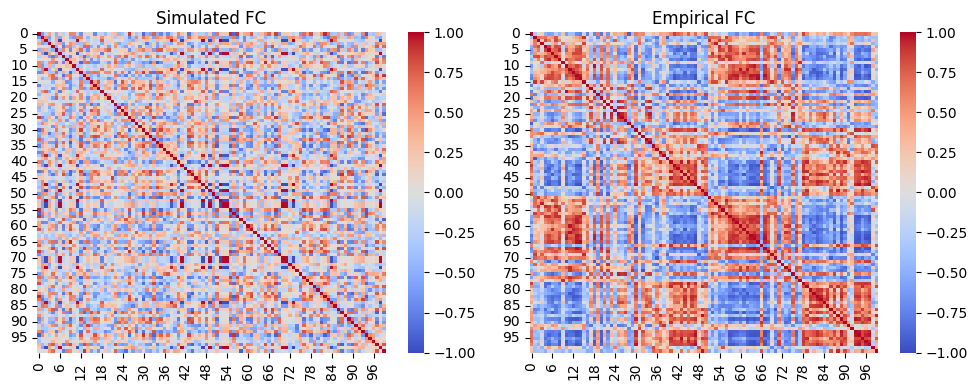

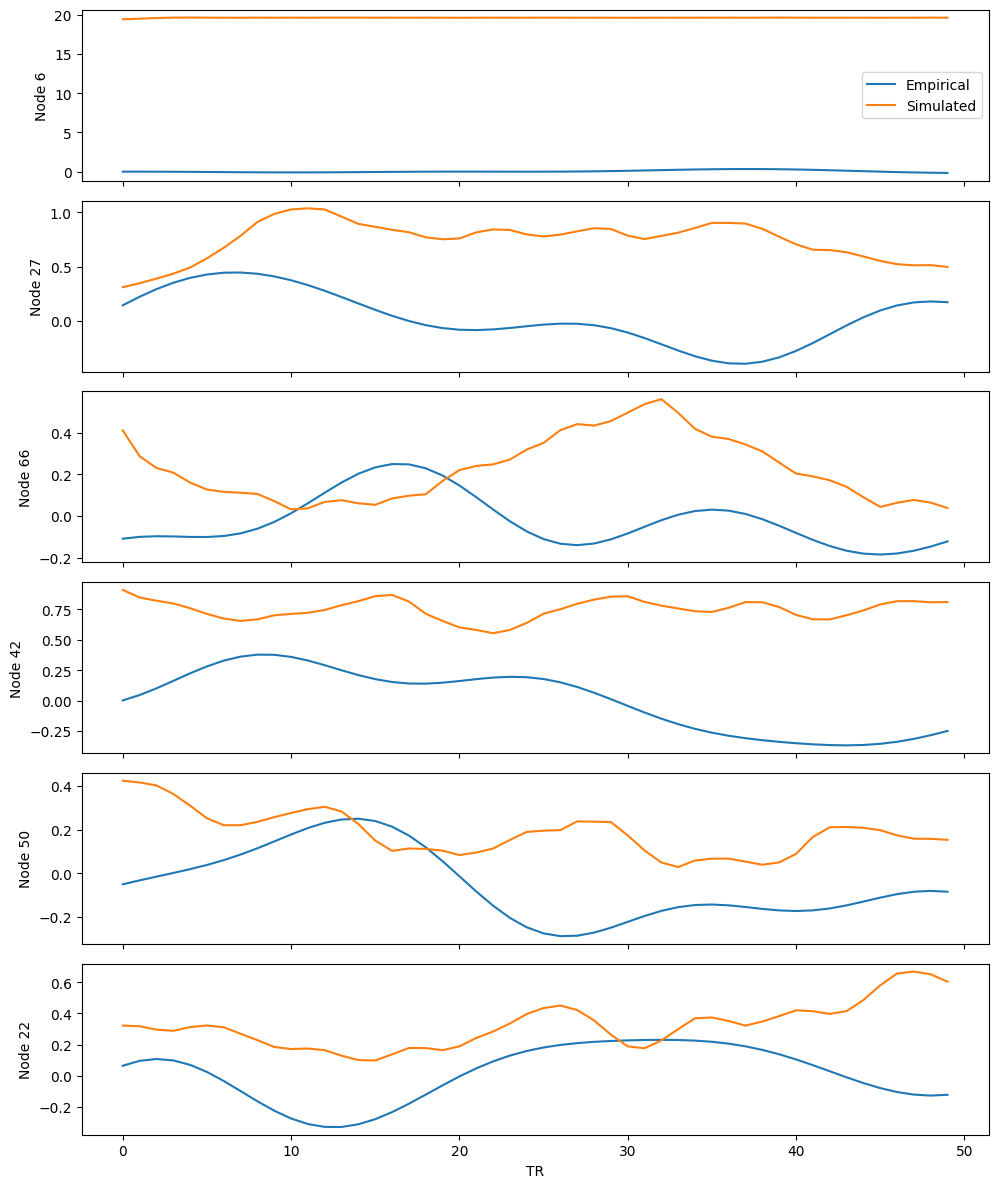

[epoch 2]  sweeping g → 141.8


Epochs [2/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  10%|█         | 1/10 [00:22<03:24, 22.73s/batch, fc_corr=-0.0005, loss=0.6936, rmse=10.6102]

SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  20%|██        | 2/10 [00:44<02:58, 22.31s/batch, fc_corr=0.0041, loss=0.6891, rmse=10.6838] 

SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  30%|███       | 3/10 [01:07<02:36, 22.31s/batch, fc_corr=-0.0032, loss=0.6963, rmse=10.6862]

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  40%|████      | 4/10 [01:29<02:14, 22.35s/batch, fc_corr=-0.0033, loss=0.6965, rmse=10.7292]

SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  50%|█████     | 5/10 [01:51<01:51, 22.34s/batch, fc_corr=-0.0069, loss=0.7001, rmse=10.7405]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  60%|██████    | 6/10 [02:14<01:29, 22.34s/batch, fc_corr=-0.0024, loss=0.6955, rmse=10.6550]

SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  70%|███████   | 7/10 [02:36<01:07, 22.38s/batch, fc_corr=0.0013, loss=0.6919, rmse=10.6499] 

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  80%|████████  | 8/10 [02:58<00:44, 22.38s/batch, fc_corr=-0.0011, loss=0.6943, rmse=10.7152]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [2/10]:  90%|█████████ | 9/10 [03:21<00:22, 22.36s/batch, fc_corr=-0.0001, loss=0.6932, rmse=10.7154]

SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 2/10 | Loss: 0.6945 | RMSE: 10.6980 | ROI Corr: 0.0039 | FC Corr: -0.0013


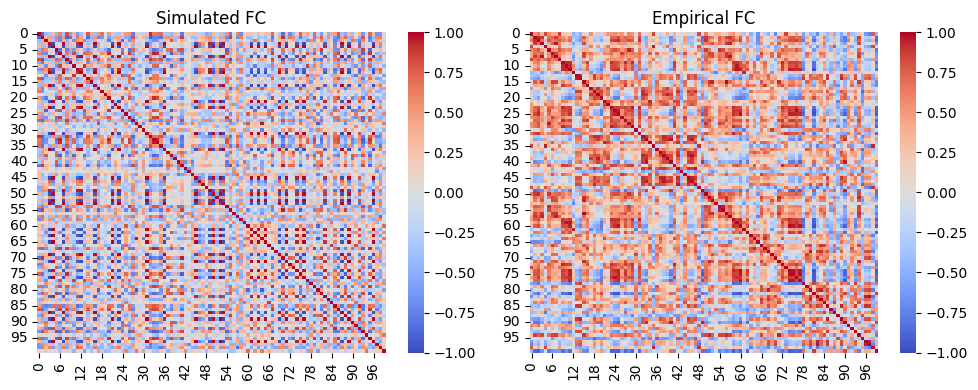

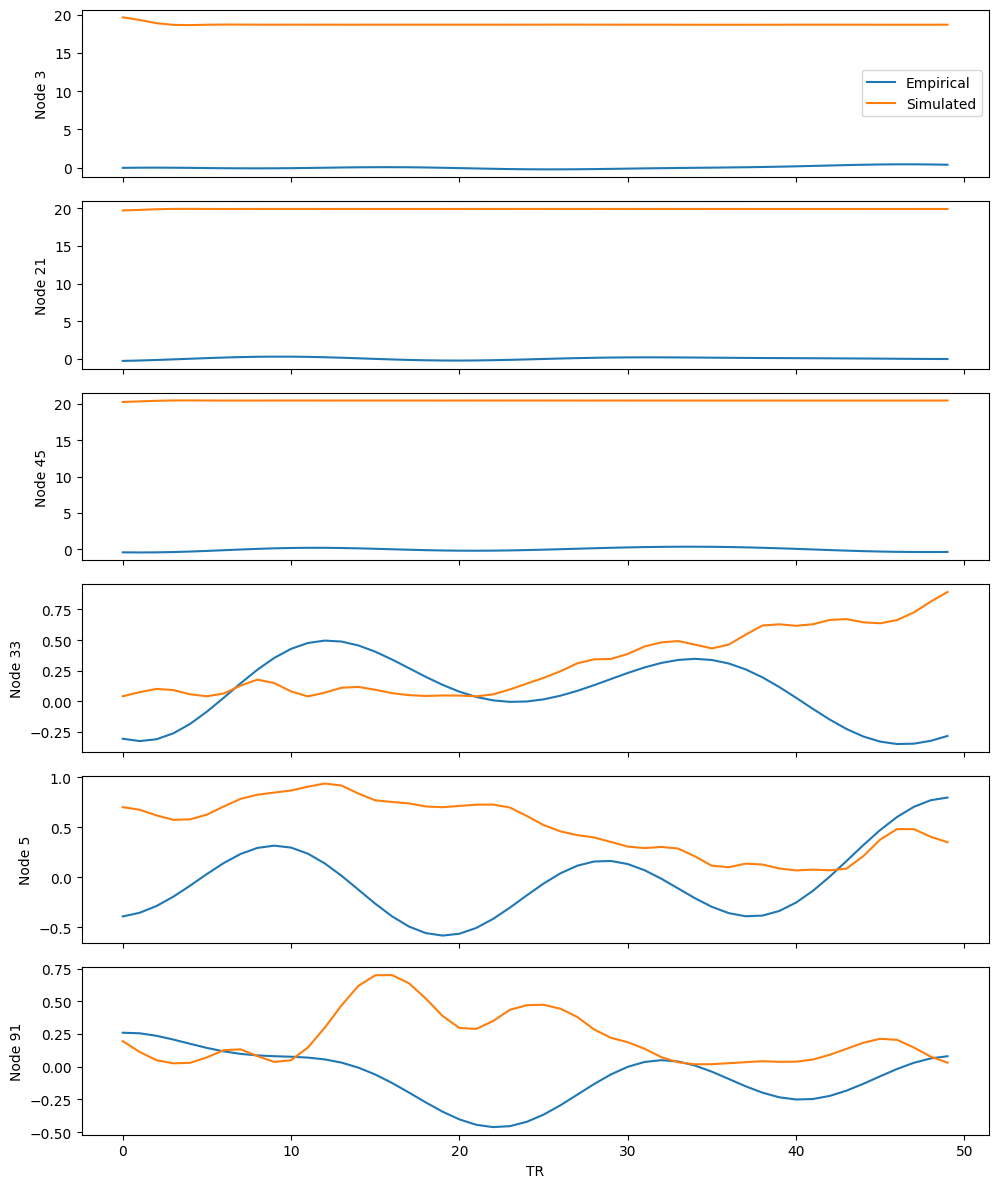

[epoch 3]  sweeping g →  24.2


Epochs [3/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.3 |corr(E)| 0.22 |corr(BOLD)| 0.21
SNR 7.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.2 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  10%|█         | 1/10 [00:22<03:20, 22.24s/batch, fc_corr=0.0018, loss=0.6914, rmse=8.7329]

SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  20%|██        | 2/10 [00:44<02:58, 22.30s/batch, fc_corr=-0.0014, loss=0.6945, rmse=8.8654]

SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  30%|███       | 3/10 [01:06<02:36, 22.30s/batch, fc_corr=0.0007, loss=0.6925, rmse=8.9673] 

SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  40%|████      | 4/10 [01:29<02:13, 22.29s/batch, fc_corr=-0.0023, loss=0.6954, rmse=9.1806]

SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  50%|█████     | 5/10 [01:51<01:51, 22.27s/batch, fc_corr=-0.0011, loss=0.6943, rmse=9.3047]

SNR 7.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  60%|██████    | 6/10 [02:14<01:29, 22.39s/batch, fc_corr=-0.0008, loss=0.6940, rmse=9.3975]

SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  70%|███████   | 7/10 [02:36<01:07, 22.35s/batch, fc_corr=0.0019, loss=0.6913, rmse=9.4265] 

SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  80%|████████  | 8/10 [02:58<00:44, 22.31s/batch, fc_corr=-0.0043, loss=0.6974, rmse=9.4404]

SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [3/10]:  90%|█████████ | 9/10 [03:21<00:22, 22.40s/batch, fc_corr=0.0052, loss=0.6880, rmse=9.4959] 

SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 3/10 | Loss: 0.6932 | RMSE: 9.2347 | ROI Corr: 0.0079 | FC Corr: -0.0001


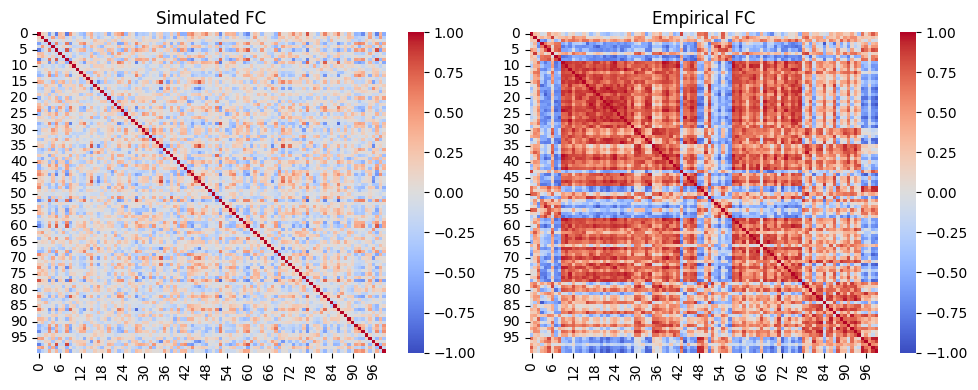

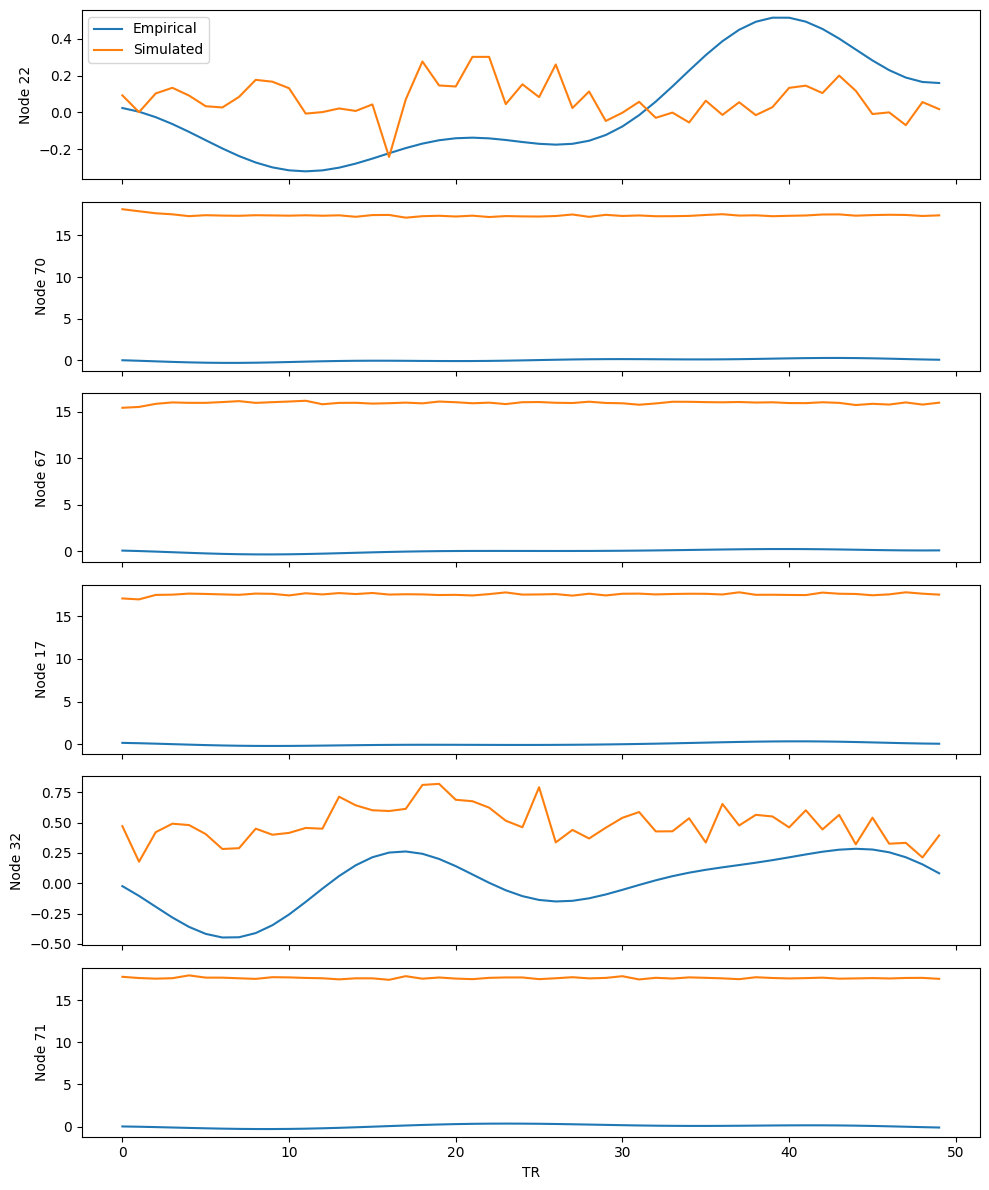

[epoch 4]  sweeping g →  39.4


Epochs [4/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  10%|█         | 1/10 [00:22<03:21, 22.43s/batch, fc_corr=-0.0078, loss=0.7010, rmse=10.1614]

SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  20%|██        | 2/10 [00:44<02:58, 22.32s/batch, fc_corr=0.0021, loss=0.6910, rmse=10.3969] 

SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  30%|███       | 3/10 [01:07<02:37, 22.47s/batch, fc_corr=0.0028, loss=0.6903, rmse=10.3994]

SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  40%|████      | 4/10 [01:29<02:14, 22.34s/batch, fc_corr=-0.0036, loss=0.6968, rmse=10.3957]

SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  50%|█████     | 5/10 [01:51<01:51, 22.28s/batch, fc_corr=-0.0010, loss=0.6941, rmse=10.4264]

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  60%|██████    | 6/10 [02:13<01:29, 22.27s/batch, fc_corr=0.0013, loss=0.6918, rmse=10.4529] 

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  70%|███████   | 7/10 [02:36<01:06, 22.30s/batch, fc_corr=0.0023, loss=0.6909, rmse=10.4927]

SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  80%|████████  | 8/10 [02:58<00:44, 22.33s/batch, fc_corr=0.0080, loss=0.6852, rmse=10.5398]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [4/10]:  90%|█████████ | 9/10 [03:21<00:22, 22.37s/batch, fc_corr=0.0026, loss=0.6906, rmse=10.6282]

SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 4/10 | Loss: 0.6930 | RMSE: 10.4673 | ROI Corr: -0.0019 | FC Corr: 0.0002


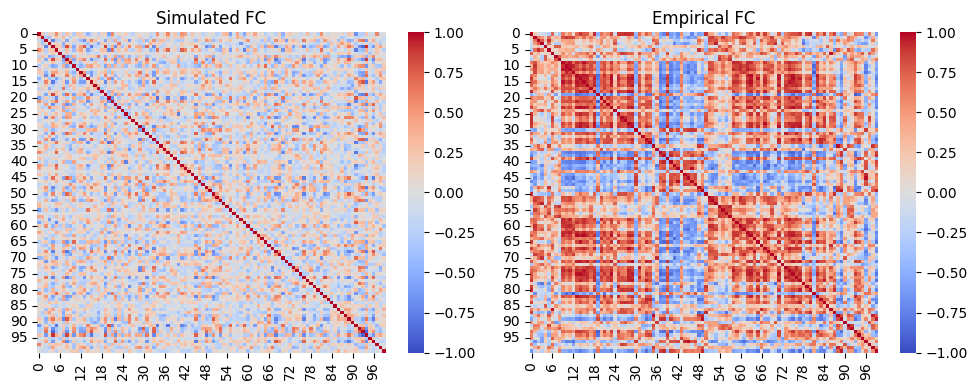

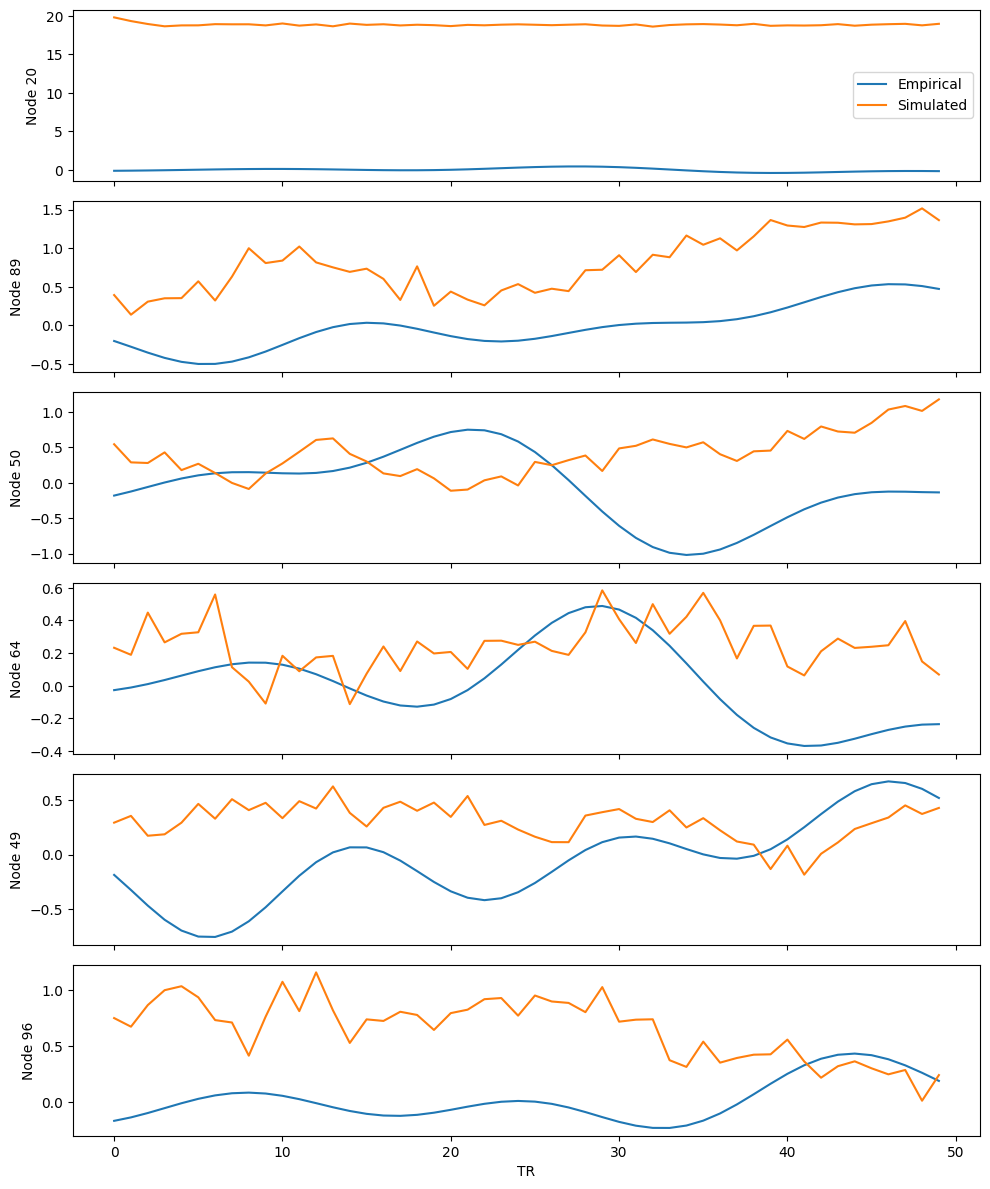

[epoch 5]  sweeping g →  17.1


Epochs [5/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 7.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  10%|█         | 1/10 [00:22<03:21, 22.41s/batch, fc_corr=-0.0009, loss=0.6940, rmse=9.8729]

SNR 8.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  20%|██        | 2/10 [00:44<02:58, 22.33s/batch, fc_corr=-0.0031, loss=0.6962, rmse=10.2812]

SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  30%|███       | 3/10 [01:06<02:36, 22.29s/batch, fc_corr=-0.0048, loss=0.6979, rmse=10.4578]

SNR 8.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  40%|████      | 4/10 [01:29<02:13, 22.26s/batch, fc_corr=-0.0023, loss=0.6954, rmse=10.6786]

SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  50%|█████     | 5/10 [01:51<01:51, 22.24s/batch, fc_corr=0.0013, loss=0.6918, rmse=10.8002] 

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  60%|██████    | 6/10 [02:13<01:28, 22.24s/batch, fc_corr=-0.0047, loss=0.6978, rmse=10.9756]

SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  70%|███████   | 7/10 [02:36<01:07, 22.35s/batch, fc_corr=-0.0060, loss=0.6992, rmse=11.1358]

SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  80%|████████  | 8/10 [02:58<00:44, 22.39s/batch, fc_corr=-0.0035, loss=0.6967, rmse=11.2395]

SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [5/10]:  90%|█████████ | 9/10 [03:20<00:22, 22.32s/batch, fc_corr=-0.0104, loss=0.7036, rmse=11.3403]

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 5/10 | Loss: 0.6971 | RMSE: 10.8158 | ROI Corr: -0.0001 | FC Corr: -0.0040


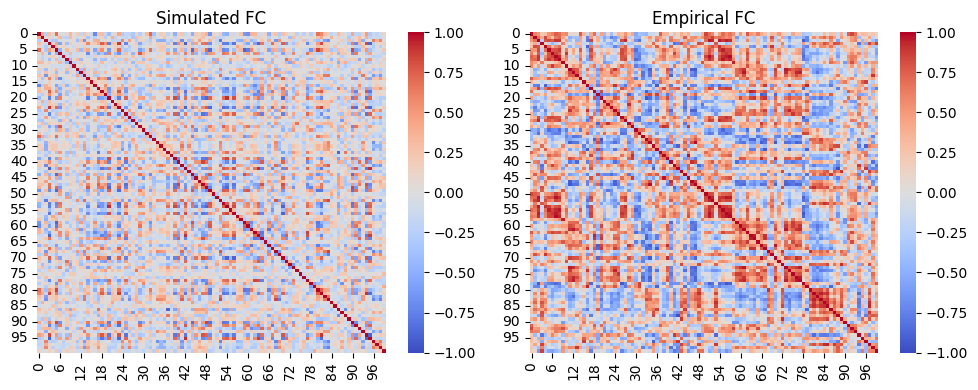

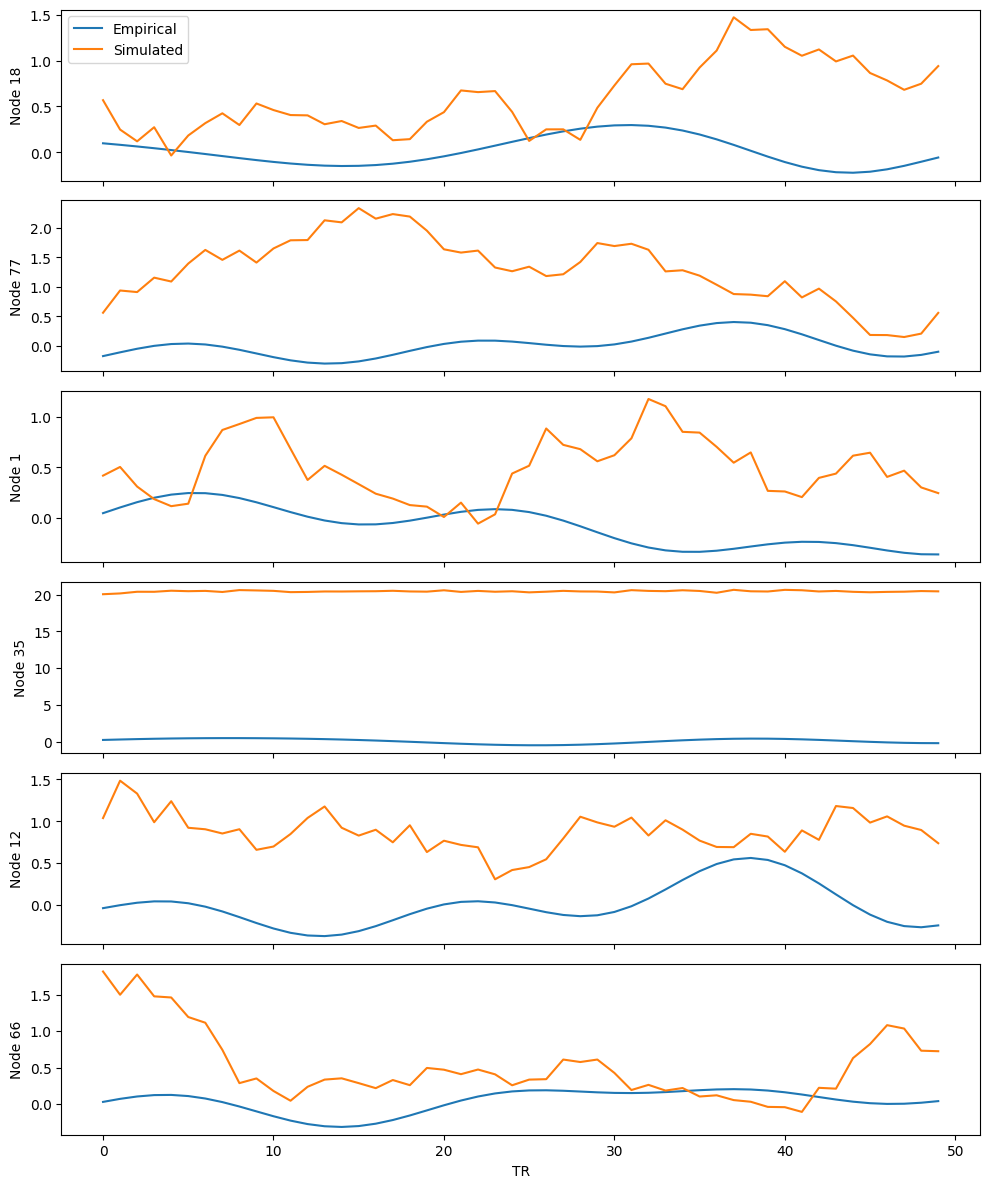

[epoch 6]  sweeping g → 139.8


Epochs [6/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  10%|█         | 1/10 [00:22<03:21, 22.44s/batch, fc_corr=-0.0015, loss=0.6946, rmse=13.5049]

SNR 10.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.5 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  20%|██        | 2/10 [00:44<02:56, 22.10s/batch, fc_corr=-0.0017, loss=0.6948, rmse=13.6936]

SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.1 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  30%|███       | 3/10 [01:06<02:35, 22.17s/batch, fc_corr=-0.0020, loss=0.6951, rmse=13.6526]

SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  40%|████      | 4/10 [01:29<02:14, 22.37s/batch, fc_corr=-0.0008, loss=0.6939, rmse=13.5479]

SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  50%|█████     | 5/10 [01:51<01:51, 22.31s/batch, fc_corr=0.0022, loss=0.6909, rmse=13.5454] 

SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  60%|██████    | 6/10 [02:13<01:29, 22.29s/batch, fc_corr=-0.0061, loss=0.6993, rmse=13.5629]

SNR 10.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  70%|███████   | 7/10 [02:36<01:06, 22.30s/batch, fc_corr=0.0008, loss=0.6924, rmse=13.5946] 

SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  80%|████████  | 8/10 [02:58<00:44, 22.36s/batch, fc_corr=-0.0016, loss=0.6947, rmse=13.5791]

SNR 10.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [6/10]:  90%|█████████ | 9/10 [03:20<00:22, 22.39s/batch, fc_corr=-0.0013, loss=0.6945, rmse=13.6045]

SNR 10.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 6/10 | Loss: 0.6947 | RMSE: 13.5942 | ROI Corr: 0.0009 | FC Corr: -0.0015


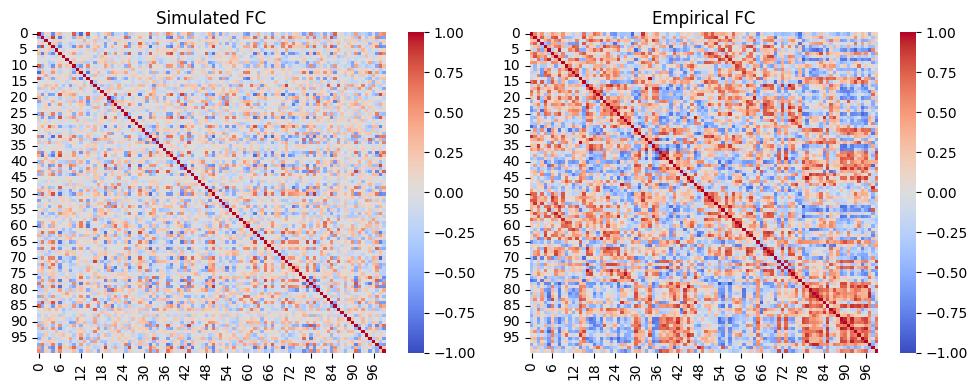

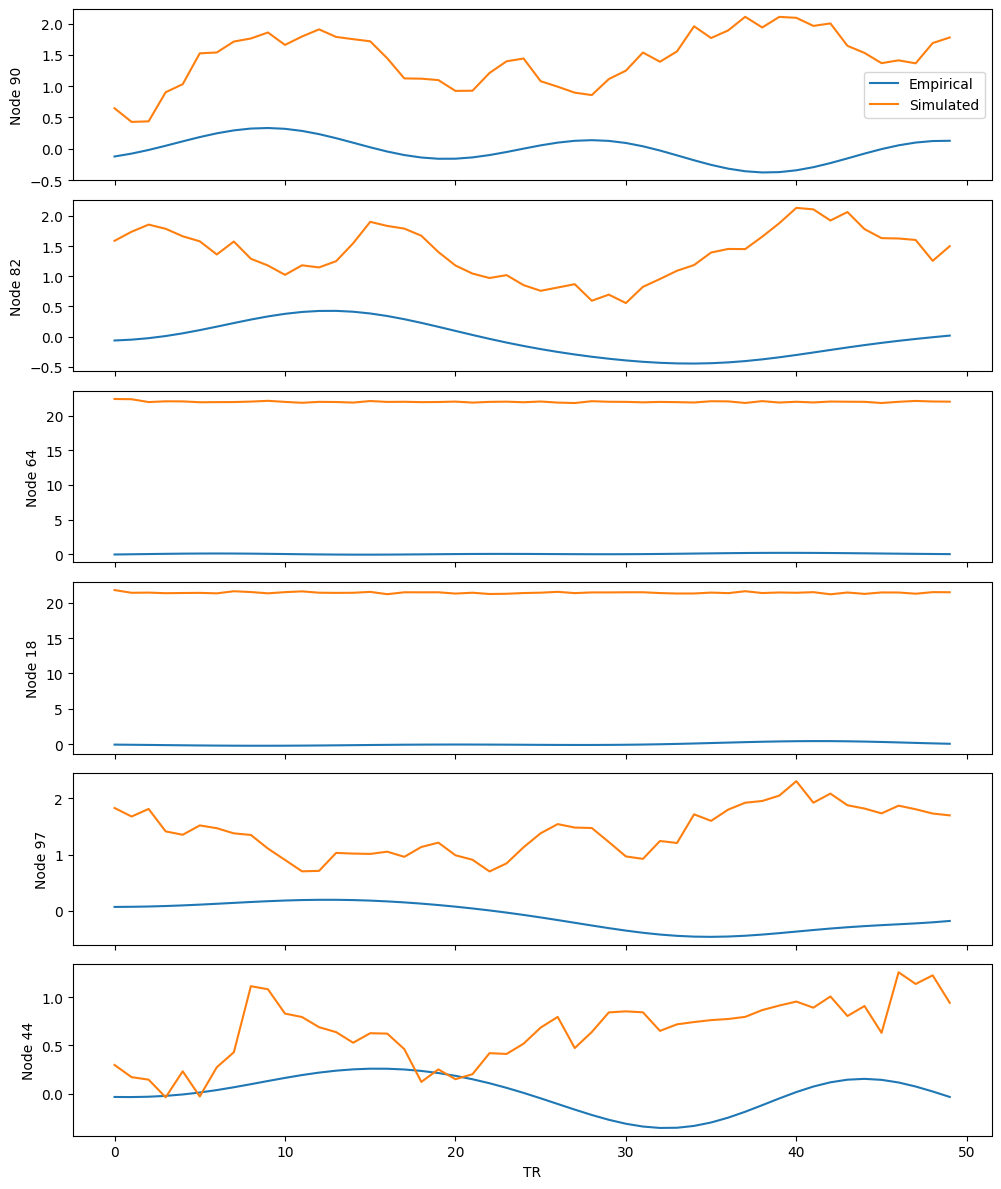

[epoch 7]  sweeping g →  66.8


Epochs [7/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  10%|█         | 1/10 [00:22<03:22, 22.53s/batch, fc_corr=-0.0082, loss=0.7014, rmse=12.9003]

SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  20%|██        | 2/10 [00:44<02:59, 22.43s/batch, fc_corr=-0.0058, loss=0.6990, rmse=13.1270]

SNR 9.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.1 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  30%|███       | 3/10 [01:07<02:37, 22.46s/batch, fc_corr=-0.0025, loss=0.6956, rmse=13.0742]

SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  40%|████      | 4/10 [01:29<02:14, 22.43s/batch, fc_corr=-0.0058, loss=0.6989, rmse=13.0351]

SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  50%|█████     | 5/10 [01:52<01:52, 22.51s/batch, fc_corr=-0.0042, loss=0.6974, rmse=12.9843]

SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  60%|██████    | 6/10 [02:14<01:30, 22.52s/batch, fc_corr=0.0023, loss=0.6909, rmse=12.8660] 

SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  70%|███████   | 7/10 [02:37<01:07, 22.57s/batch, fc_corr=0.0064, loss=0.6868, rmse=12.8227]

SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  80%|████████  | 8/10 [03:00<00:45, 22.62s/batch, fc_corr=0.0001, loss=0.6930, rmse=12.7940]

SNR 9.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 10.2 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [7/10]:  90%|█████████ | 9/10 [03:22<00:22, 22.60s/batch, fc_corr=0.0016, loss=0.6916, rmse=12.7876]

SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 7/10 | Loss: 0.6940 | RMSE: 12.9177 | ROI Corr: 0.0025 | FC Corr: -0.0008


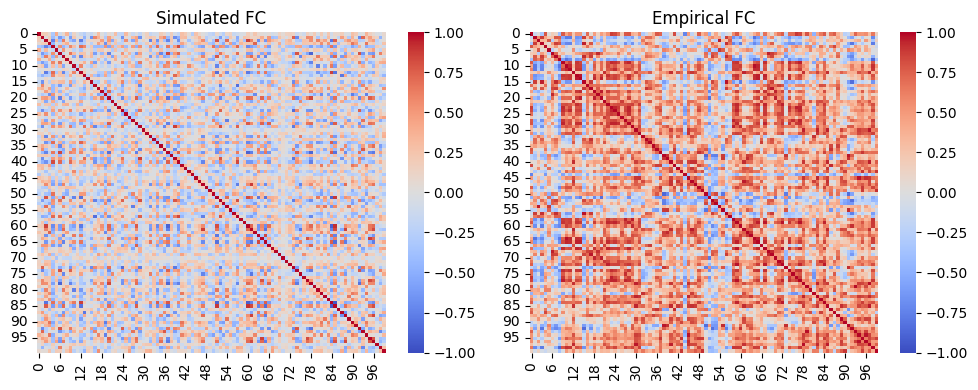

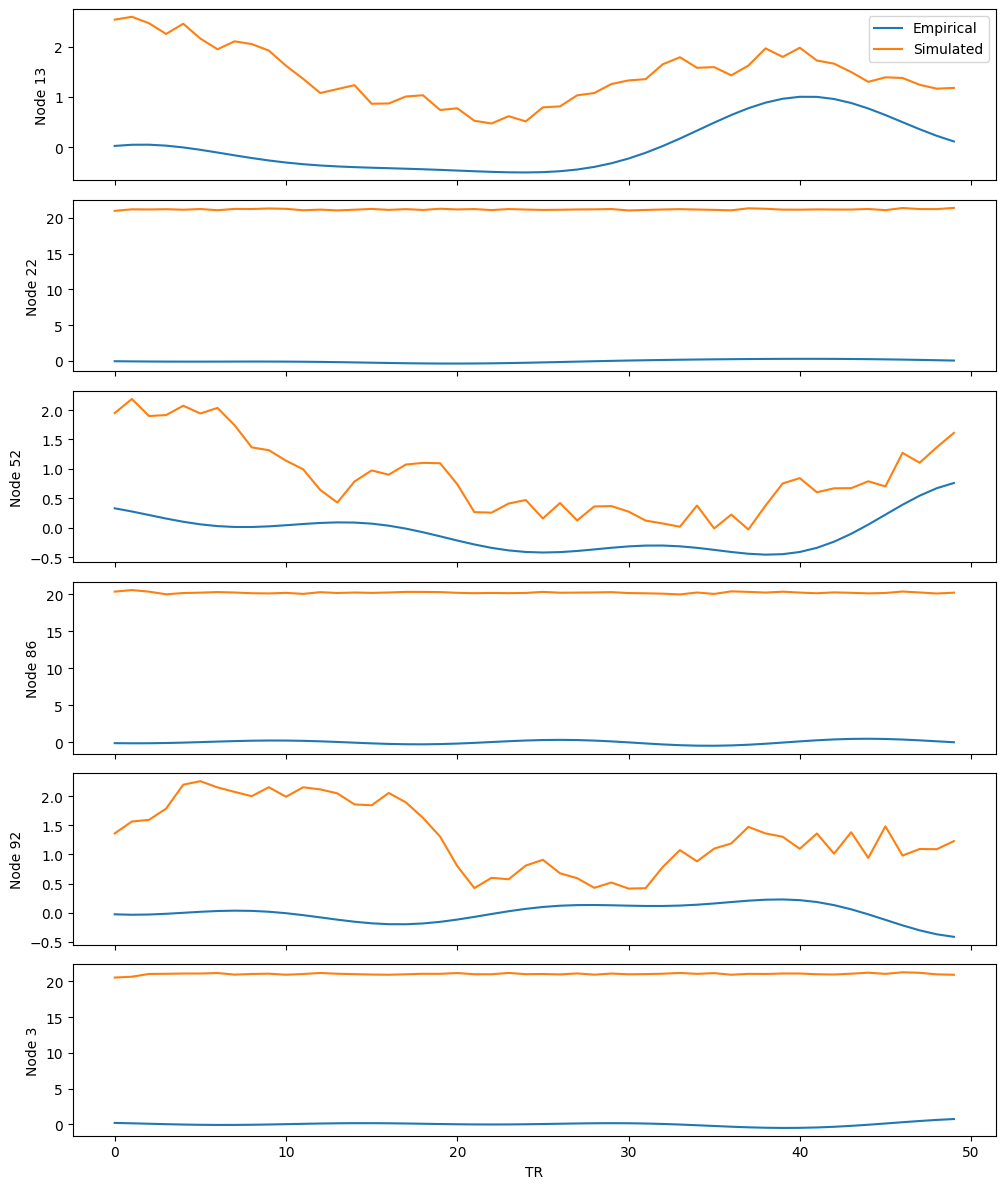

[epoch 8]  sweeping g →  41.2


Epochs [8/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  10%|█         | 1/10 [00:22<03:21, 22.43s/batch, fc_corr=0.0022, loss=0.6910, rmse=12.2123]

SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  20%|██        | 2/10 [00:44<02:57, 22.18s/batch, fc_corr=-0.0001, loss=0.6933, rmse=12.4528]

SNR 9.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  30%|███       | 3/10 [01:06<02:35, 22.24s/batch, fc_corr=0.0002, loss=0.6929, rmse=12.3977] 

SNR 9.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  40%|████      | 4/10 [01:29<02:13, 22.25s/batch, fc_corr=-0.0003, loss=0.6934, rmse=12.2704]

SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.4 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  50%|█████     | 5/10 [01:51<01:51, 22.30s/batch, fc_corr=0.0029, loss=0.6902, rmse=12.1653] 

SNR 9.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  60%|██████    | 6/10 [02:13<01:28, 22.24s/batch, fc_corr=0.0017, loss=0.6914, rmse=11.9865]

SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  70%|███████   | 7/10 [02:36<01:06, 22.32s/batch, fc_corr=0.0000, loss=0.6931, rmse=11.8487]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  80%|████████  | 8/10 [02:58<00:44, 22.38s/batch, fc_corr=-0.0002, loss=0.6933, rmse=11.7616]

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [8/10]:  90%|█████████ | 9/10 [03:21<00:22, 22.46s/batch, fc_corr=-0.0055, loss=0.6986, rmse=11.6566]

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 8/10 | Loss: 0.6922 | RMSE: 12.0281 | ROI Corr: -0.0074 | FC Corr: 0.0009


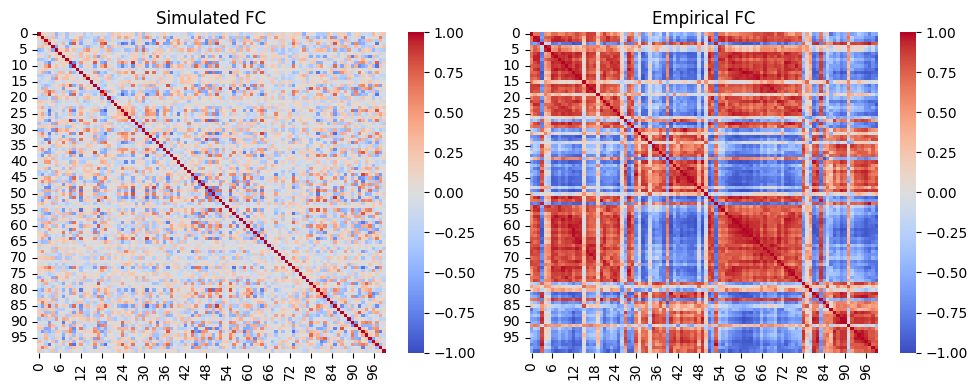

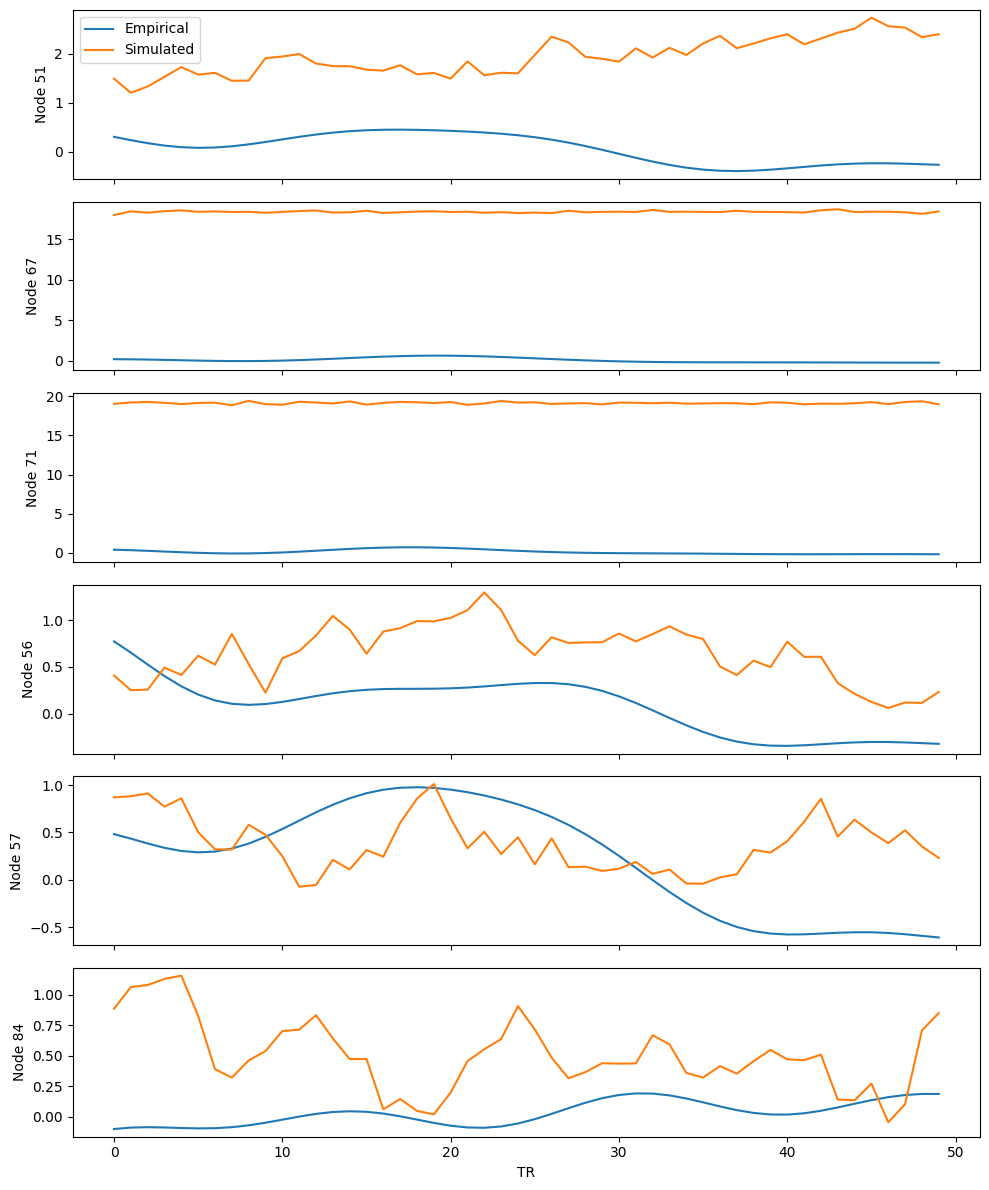

[epoch 9]  sweeping g → 165.6


Epochs [9/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.2 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.1 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.1 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  10%|█         | 1/10 [00:22<03:23, 22.66s/batch, fc_corr=-0.0094, loss=0.7026, rmse=12.1484]

SNR 9.1 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.3 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  20%|██        | 2/10 [00:45<03:00, 22.55s/batch, fc_corr=0.0021, loss=0.6911, rmse=12.2776] 

SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.1 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.1 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.6 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  30%|███       | 3/10 [01:07<02:37, 22.48s/batch, fc_corr=0.0009, loss=0.6922, rmse=12.1712]

SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  40%|████      | 4/10 [01:29<02:14, 22.36s/batch, fc_corr=0.0015, loss=0.6916, rmse=12.1159]

SNR 9.1 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  50%|█████     | 5/10 [01:51<01:51, 22.28s/batch, fc_corr=0.0027, loss=0.6904, rmse=12.0506]

SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.6 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  60%|██████    | 6/10 [02:14<01:29, 22.33s/batch, fc_corr=0.0003, loss=0.6928, rmse=11.9756]

SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  70%|███████   | 7/10 [02:36<01:06, 22.32s/batch, fc_corr=-0.0009, loss=0.6940, rmse=11.9271]

SNR 9.0 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  80%|████████  | 8/10 [02:59<00:44, 22.45s/batch, fc_corr=0.0032, loss=0.6899, rmse=11.9184] 

SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.7 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.4 |corr(E)| 0.21 |corr(BOLD)| 0.21


Epochs [9/10]:  90%|█████████ | 9/10 [03:21<00:22, 22.36s/batch, fc_corr=-0.0032, loss=0.6963, rmse=11.9245]

SNR 8.9 |corr(E)| 0.21 |corr(BOLD)| 0.21
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.21
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.21
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.21


Epoch 9/10 | Loss: 0.6932 | RMSE: 12.0452 | ROI Corr: 0.0014 | FC Corr: -0.0001


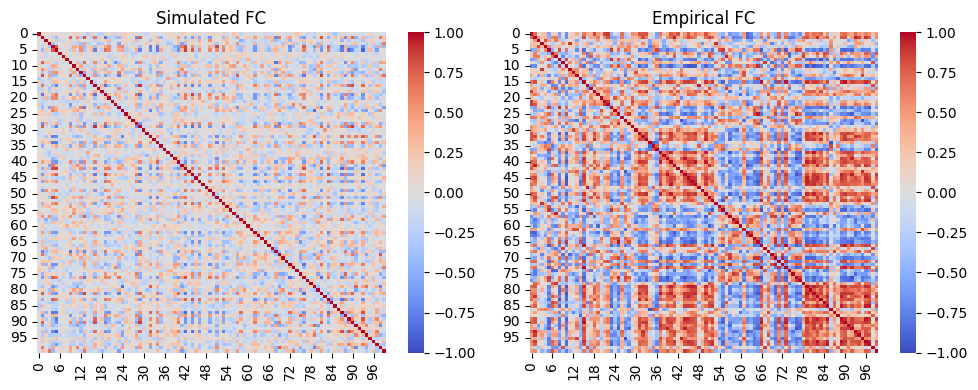

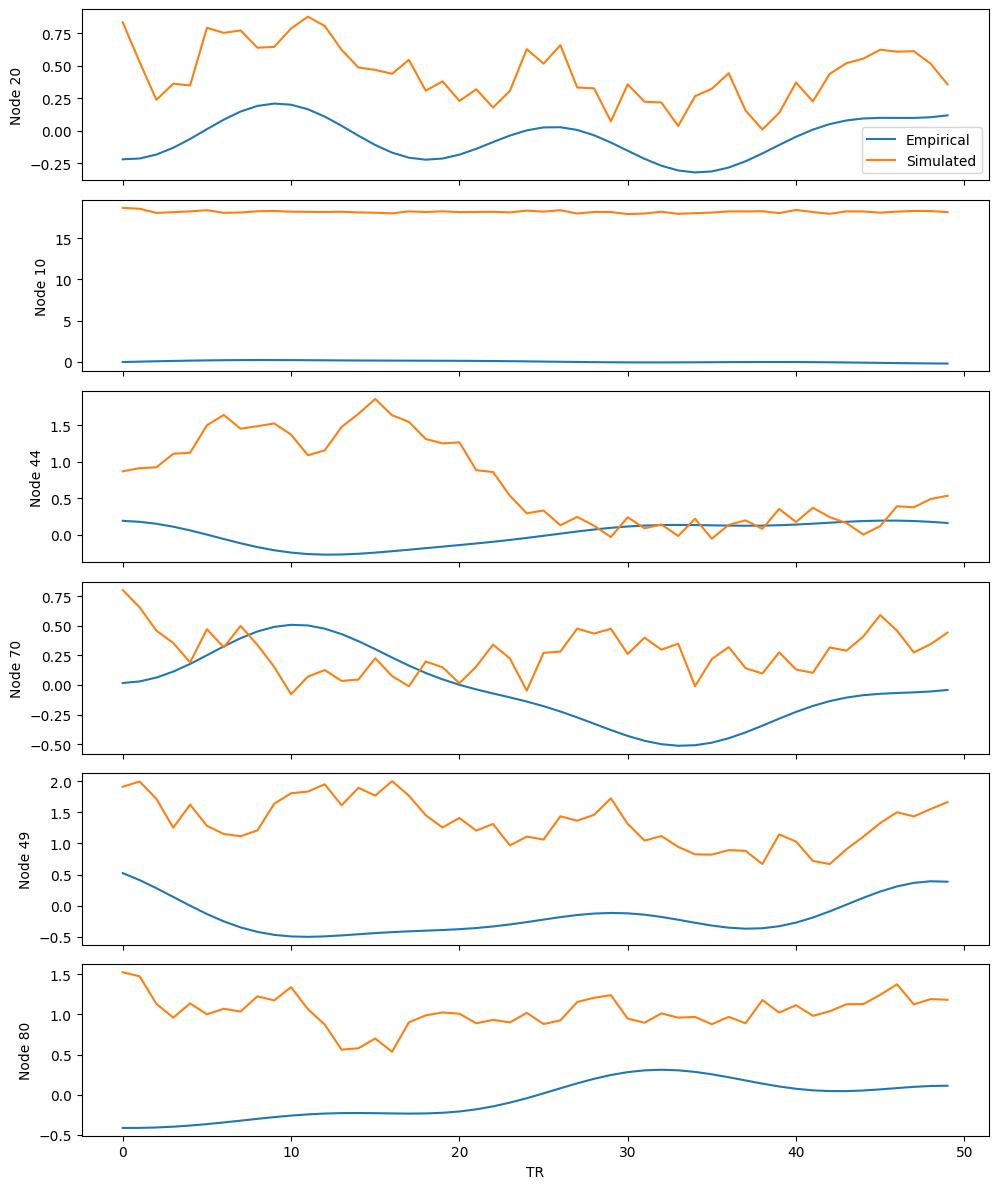

[epoch 10]  sweeping g →  49.9


Epochs [10/10]:   0%|          | 0/10 [00:00<?, ?batch/s]

SNR 2.1 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  10%|█         | 1/10 [00:22<03:23, 22.63s/batch, fc_corr=0.0028, loss=0.6903, rmse=11.1559]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.3 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  20%|██        | 2/10 [00:45<03:01, 22.74s/batch, fc_corr=-0.0048, loss=0.6980, rmse=11.4211]

SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.4 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  30%|███       | 3/10 [01:07<02:37, 22.54s/batch, fc_corr=-0.0034, loss=0.6965, rmse=11.4805]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  40%|████      | 4/10 [01:30<02:15, 22.57s/batch, fc_corr=-0.0059, loss=0.6991, rmse=11.5099]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  50%|█████     | 5/10 [01:52<01:52, 22.57s/batch, fc_corr=-0.0001, loss=0.6933, rmse=11.5273]

SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  60%|██████    | 6/10 [02:15<01:29, 22.44s/batch, fc_corr=-0.0027, loss=0.6958, rmse=11.5653]

SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  70%|███████   | 7/10 [02:37<01:06, 22.29s/batch, fc_corr=0.0012, loss=0.6919, rmse=11.5838] 

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  80%|████████  | 8/10 [02:59<00:44, 22.26s/batch, fc_corr=0.0017, loss=0.6914, rmse=11.6221]

SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 9.0 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.9 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epochs [10/10]:  90%|█████████ | 9/10 [03:21<00:22, 22.26s/batch, fc_corr=-0.0011, loss=0.6942, rmse=11.6359]

SNR 8.7 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.6 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.5 |corr(E)| 0.22 |corr(BOLD)| 0.22
SNR 8.8 |corr(E)| 0.22 |corr(BOLD)| 0.22


Epoch 10/10 | Loss: 0.6943 | RMSE: 11.5159 | ROI Corr: -0.0012 | FC Corr: -0.0012


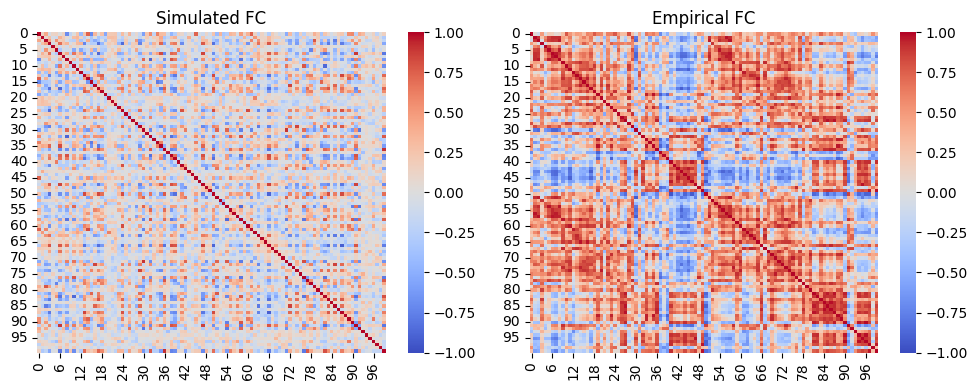

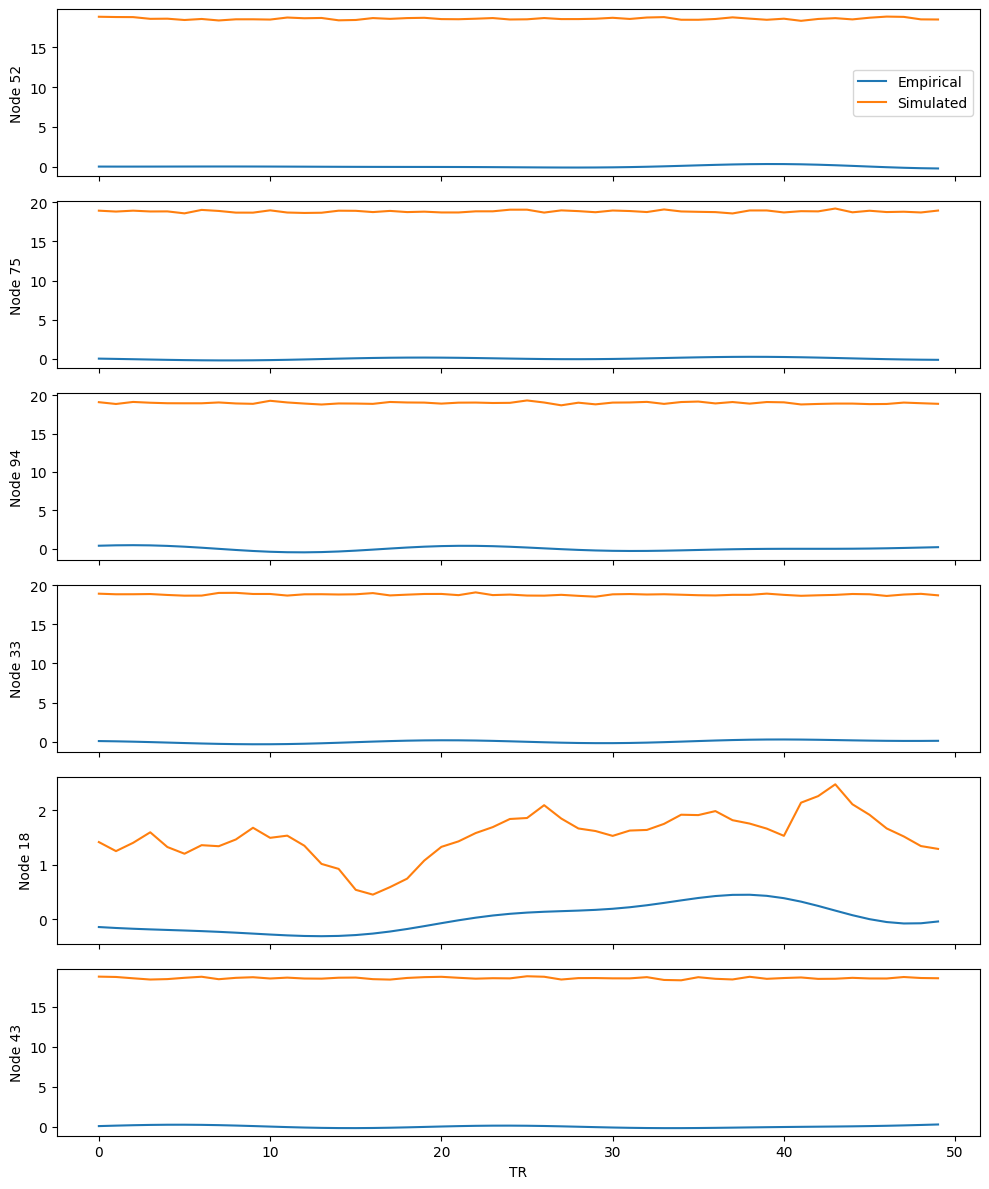

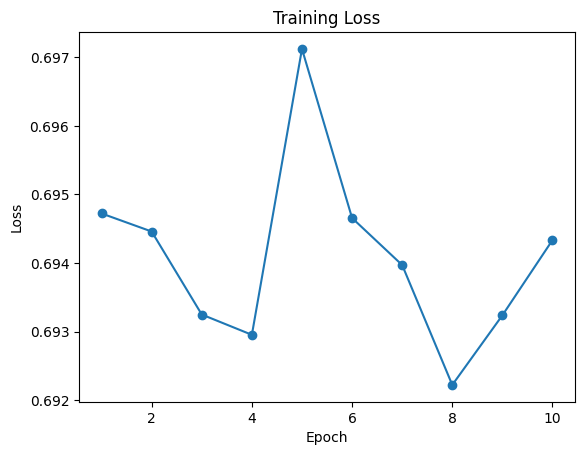

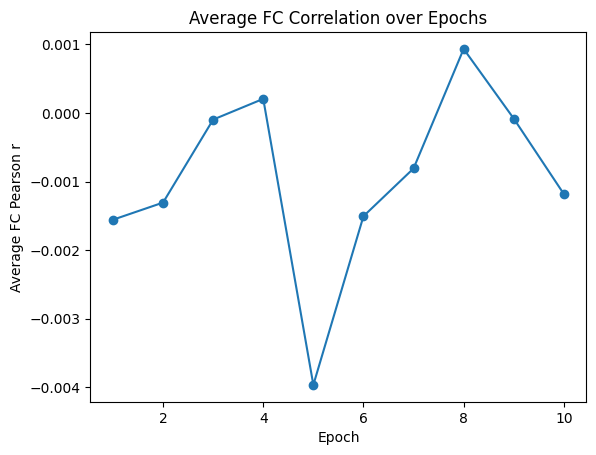

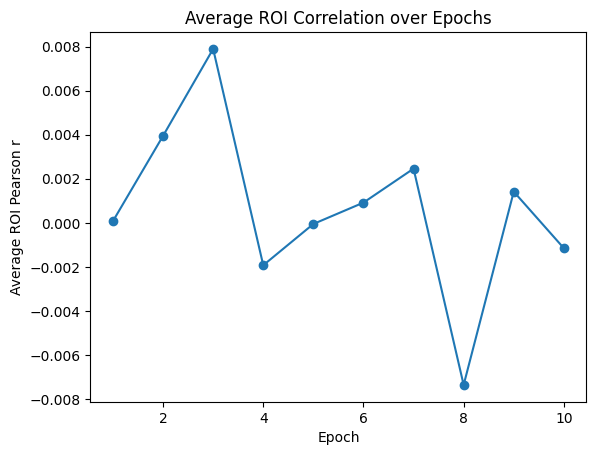

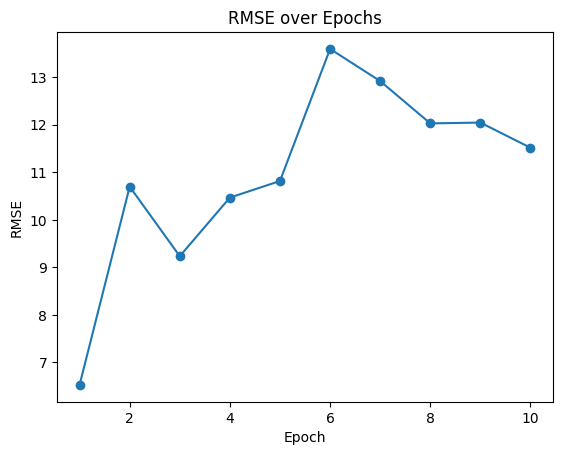

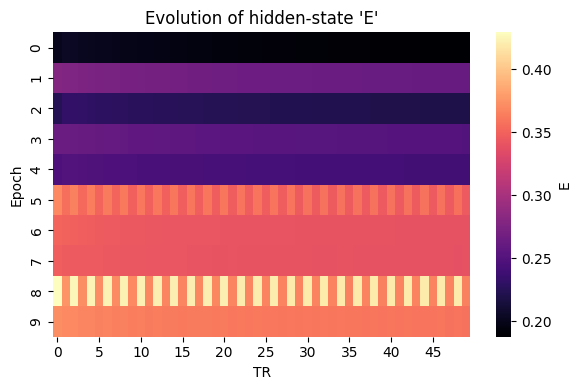

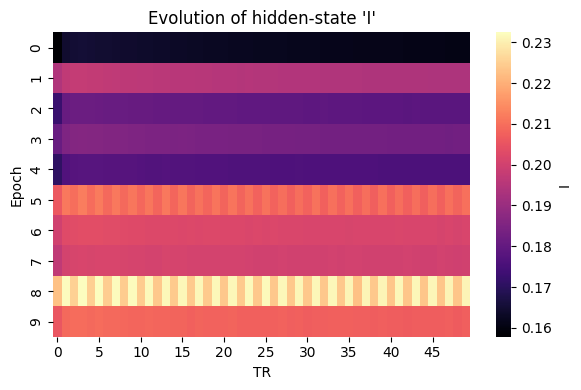

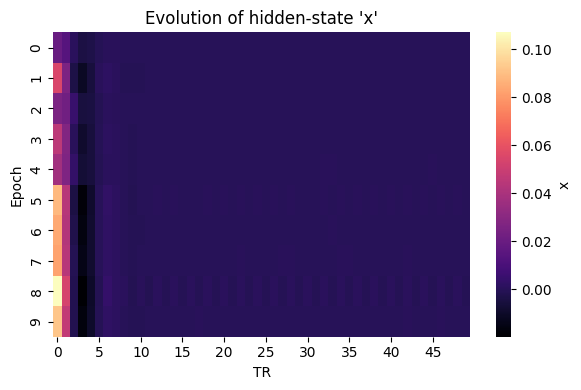

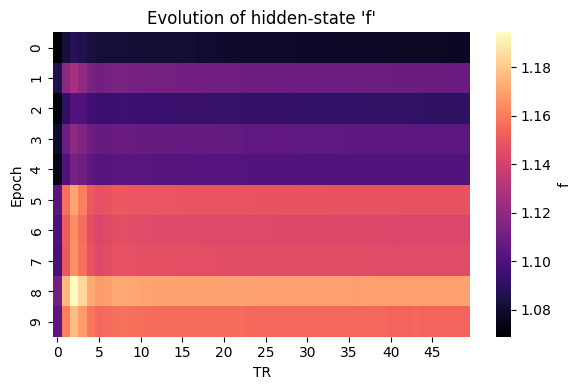

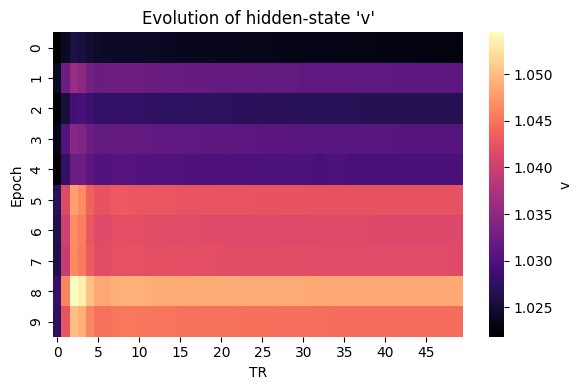

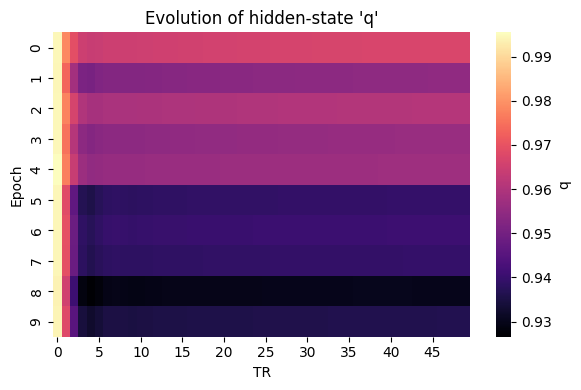

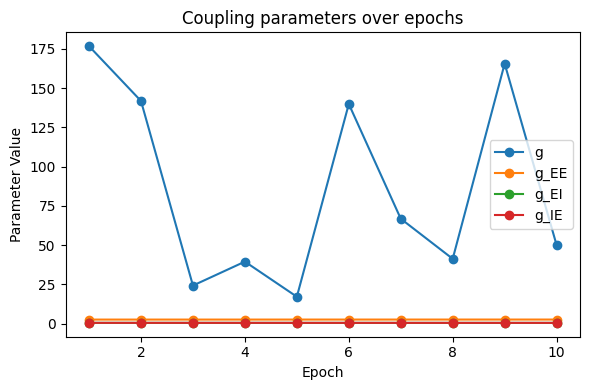

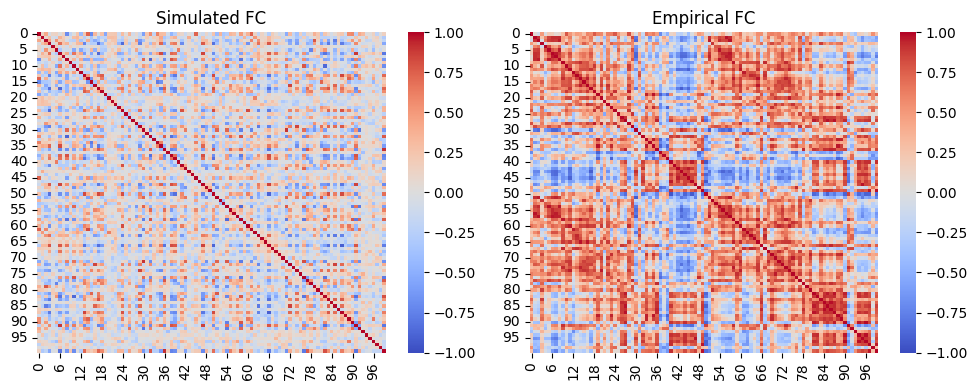

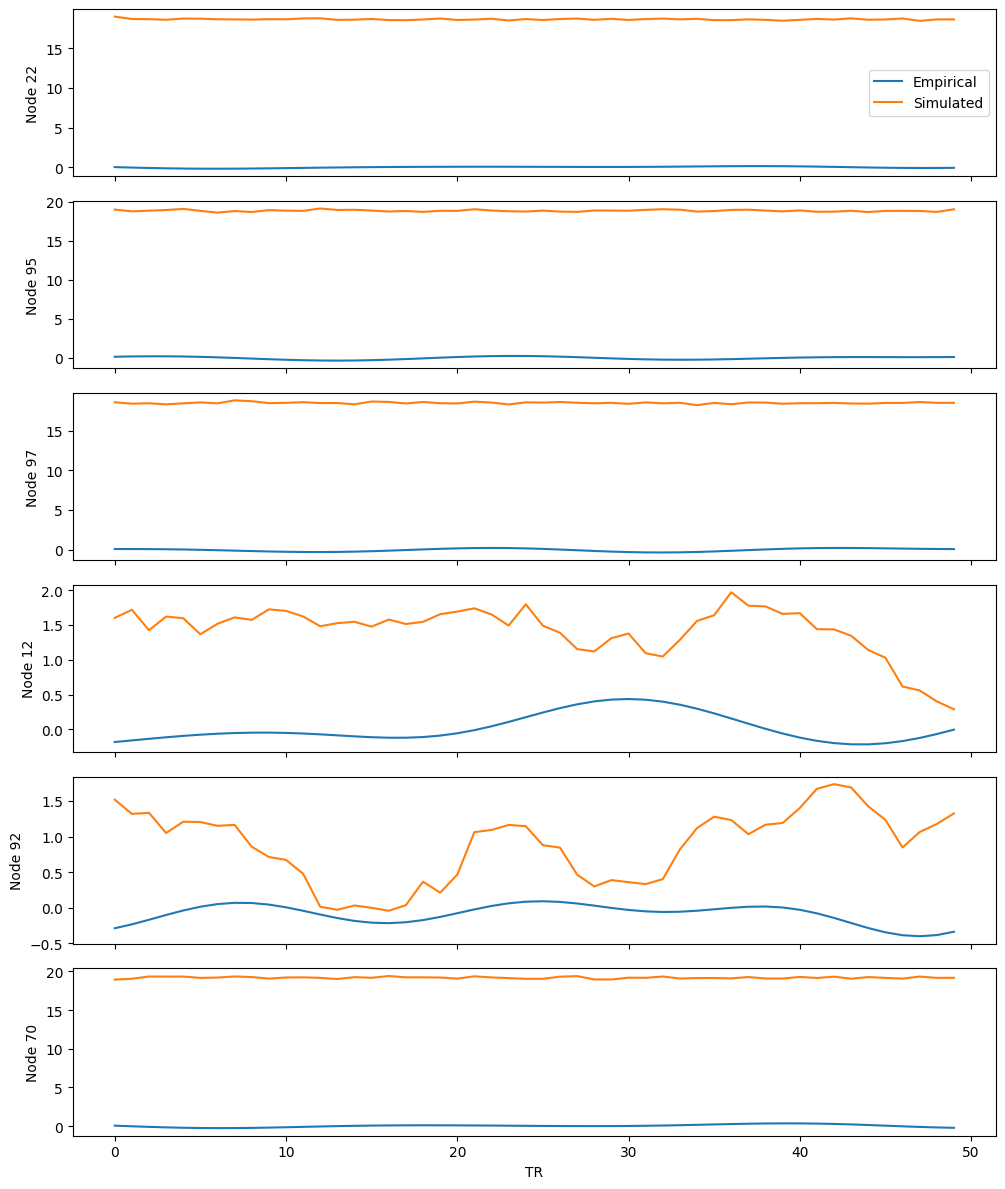

W_E 1.007230281829834
W_I 0.6925228238105774
I_0 0.3271738290786743
tau_E 100.01134490966797
tau_I 10.002326011657715
gamma_E 0.019027674570679665
sigma_E 0.009655453264713287
sigma_I 0.013391350395977497
sigma_BOLD 0.10742291063070297
aE 310.01727294921875
bE 124.99275207519531
dE 0.16301418840885162
aI 614.9917602539062
bI 177.00753784179688
dI 0.09340231865644455
g 49.929073333740234
g_EE 2.521961212158203
g_IE 0.4086840748786926
g_EI 0.396861732006073
tau_s 0.6310041546821594
tau_f 0.42626720666885376
tau_0 0.9841510653495789
alpha 0.3207010328769684
rho 0.3239705562591553
k1 2.3721201419830322
k2 1.9900487661361694
k3 0.48943015933036804
V 0.08521600067615509
E0 0.35489845275878906
[Main] Training complete


In [67]:
trainer.train(delays_max, batch_size)

print("[Main] Training complete")


### Impulse Test

In [ ]:
@torch.no_grad()
def coupling_impulse_test(model, g_val, n_nodes=8, n_TR=100):
    """
    Stimulate node 0 with a single-TR pulse and plot mean E over time
    for the other nodes.  Run with g=0 and a large g to see the effect.
    """

    old_g = model.g.data.clone()
    model.g.data = g_val           # set global coupling
    print(f"g_val: {g_val}")

    B = 1
    state  = model.generate_initial_states()[:, :model.state_size, :B]
    delays = torch.zeros(model.node_size, model.delays_max, B)

    # external pulse: 1 at first hidden step for node 0
    external = torch.zeros(model.node_size, model.hidden_size, B)
    external[0, 0] = 1.0

    E_traj = []
    for _ in range(n_TR):
        noise_in  = torch.zeros(model.node_size, model.hidden_size,
                                model.input_size, B)
        noise_out = torch.zeros(model.node_size, B)
        state, _, delays = model(state, external, noise_in,
                                 noise_out, delays,
                                 batched_laplacian=torch.zeros(B, n_nodes, n_nodes),
                                 dist_matrices=torch.zeros(B, n_nodes, n_nodes))
        E_traj.append(state[:,0,:].squeeze())   # store E only
        external.zero_()   # pulse only on the first TR
    
    model.g.data.copy_(old_g)          # restore original g
    E_traj = torch.stack(E_traj, 1)    # (node, time)
    plt.plot(E_traj[0].cpu(), label='stim node')
    plt.plot(E_traj[1:].mean(0).cpu(), label='mean of others')
    plt.title(f'Impulse response, g={g_val}')
    plt.legend(); plt.xlabel('TR'); plt.ylabel('E')
    plt.show()

model = WholeBrainModel(params, input_size, 8, 1, step_size, tr, 20)

coupling_impulse_test(model, torch.tensor(0, dtype=torch.float32))


### Coupling Experiments

In [31]:
import copy

torch.manual_seed(0)

test_batch_size = 1
test_delays_max = 50
params = ModelParams()
model = WholeBrainModel(params, input_size, node_size, test_batch_size, step_size, tr, test_delays_max)
device = next(model.parameters()).device

_, laplacians, dist_matrices, _ = data_loader.sample_minibatch(test_batch_size)

model_coup = copy.deepcopy(model)
model_coup.g.data.fill_(400.)
model_noc  = copy.deepcopy(model)
model_noc.g.data.fill_(0.)

def run(model, laplacians, dist_matrices, device):
    print(f"[STARTING RUN] - g = {model.g.item()}, g_EE = {model.g_EE.item()}, sigma_E = {model.sigma_E.item()}, sigma_I = {model.sigma_I.item()}, sigma_BOLD = {model.sigma_BOLD.item()}")
    laplacians     = laplacians.to(device)
    dist_matrices  = dist_matrices.to(device)

    
    state = model.generate_initial_states().to(device)
    delays = torch.zeros(model.node_size, test_delays_max, test_batch_size)
    bold = []
    e = []
    for _ in range(100):
        noise_in  = torch.randn(node_size, model.hidden_size, input_size, test_batch_size, device=device)
        noise_out = torch.randn(node_size, test_batch_size, device=device)

        ext = torch.zeros(node_size, model.hidden_size, test_batch_size, device=device)
        state, y, delays = model(state, ext, noise_in, noise_out, delays, laplacians, dist_matrices)
        # print('SNR =', ((y - noise_out).std() / noise_out.std()).item())
        e.append(state[:, 0, :].detach().squeeze(1))
        print(state[:, 0, :].mean().item())
        bold.append(y.mean(1))
    return torch.stack(bold), torch.stack(e)

bold_400, e_400 = run(model_coup, laplacians, dist_matrices, device)
bold_0, e_0 = run(model_noc, laplacians, dist_matrices, device)

print('std bold (g=400):', bold_400.std().item(), 'std bold (g=0):', bold_0.std().item())
print('CORR BOLD       :', torch.corrcoef(bold_400.T).abs().mean().item(),
                             torch.corrcoef(bold_0.T).abs().mean().item())
print('CORR E          :', torch.corrcoef(e_400).abs().mean().item(),
                             torch.corrcoef(e_0).abs().mean().item())




[DEBUG] Model initialized with 6 states, 29 learnable parameters, and 15 hidden step size
[STARTING RUN] - g = 400.0, g_EE = 2.5, sigma_E = 0.019999999552965164, sigma_I = 0.019999999552965164, sigma_BOLD = 0.019999999552965164
0.34676799178123474
0.33873772621154785
0.3310260474681854
0.326227605342865
0.3212602734565735
0.3191368877887726
0.31693708896636963
0.3129013180732727
0.31192463636398315
0.31018397212028503
0.30846157670021057
0.3064529299736023
0.3059980273246765
0.3047659993171692
0.30457109212875366
0.305608332157135
0.304277241230011
0.3027627766132355
0.3024885952472687
0.30187851190567017
0.3003745973110199
0.2987288236618042
0.2978981137275696
0.298061728477478
0.2971906065940857
0.2967502474784851
0.30005285143852234
0.29807692766189575
0.2991199195384979
0.2994721233844757
0.30013370513916016
0.30186471343040466
0.3001541793346405
0.29975783824920654
0.2995337247848511
0.29842454195022583
0.2970705032348633
0.29795894026756287
0.2970106601715088
0.29881367087364197
